# Results for Multi-modal Approaches

Evaluation metrics used:

- ROC/AUC
- Accuracy 
- Precision
- Recall
- F1-score

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_addons as tfa

from pathlib import Path
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, ConvLSTM1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

## Methods for loading datasets and creating model architectures

In [3]:
def load_file(file):
    df = pd.read_csv(file, header=0)
    labels = df['pain']
    df = df.drop(columns=['pain'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df, labels

def load_dataset(input_filepath, modality):
    feature_names = []
    classes = []
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if feature_names == []:
                feature_names = x.columns.values.tolist()
            if labels[0] not in classes:
                classes.append(labels[0])
            x = x.to_numpy()
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            x = x.to_numpy()
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test, feature_names, classes

def load_earlyfusion_dataset(input_filepath):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    body_train_filepath = data_dir / input_filepath / 'train' / 'skeleton'
    body_test_filepath = data_dir / input_filepath / 'test' / 'skeleton'
    face_train_filepath = data_dir / input_filepath / 'train' / 'AUs'
    face_test_filepath = data_dir / input_filepath / 'test' / 'AUs'
    # 1. Load train data
    X = list()
    y = list()
    for file in body_train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            has_equivalent_face_file = False
            for second_file in face_train_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    body_x = body_x.to_numpy()
                    face_x = face_x.to_numpy()
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in body_test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            body_x = body_x.to_numpy()
            has_equivalent_face_file = False
            for second_file in face_test_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    face_x = face_x.to_numpy()
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

def load_latefusion_dataset(input_filepath, modality):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if modality == 'skeleton':
                has_equivalent_face_file = False 
                for second_file in (data_dir / input_filepath / 'train' / 'AUs').iterdir():
                    if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                        has_equivalent_face_file = True
                        break
                if not has_equivalent_face_file:
                    continue
                else: 
                    x = x.to_numpy()
                    X.append(x)
                    y.append(labels[0])
            else:
                x = x.to_numpy()
                X.append(x)
                y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if modality == 'skeleton':
                has_equivalent_face_file = False 
                for second_file in (data_dir / input_filepath / 'test' / 'AUs').iterdir():
                    if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                        has_equivalent_face_file = True
                        break
                if not has_equivalent_face_file:
                    continue
                else: 
                    x = x.to_numpy()
                    X.append(x)
                    y.append(labels[0])
            else:
                x = x.to_numpy()
                X.append(x)
                y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

In [4]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


In [5]:
def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2, class_weight=class_weight)
    return history

def train_fusioned(model, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10)
    history = model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], class_weight=class_weight, verbose=2)
    return history

### Bidirectional LSTM Model

Bidrectional LSTM runs the input in two ways (past to future and future to past) making it possible to preserve information both backwards and forwards. I included this layer type anticipating it could be suited for making the model understand context to assess any experience of pain. 

Additionally, bidrectional LSTM is used by [Bargshady et al.](https://pubmed.ncbi.nlm.nih.gov/34756219/) in an Ensemble combination of CNN+BiLSTM models for facial expressions modality. Their settings: 

- filters: 256
- dense: 4096

In [6]:
def build_biLSTM(n_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input = Input(shape=(1, n_length, n_features))
    bilstm_1 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout))(input)
    bilstm_2 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout))(bilstm_1)
    bilstm_3 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(bilstm_2)
    flatten = Flatten()(bilstm_3)
    dense = Dense(neurons, activation=activation)(flatten)
    dense = Dense(neurons, activation=activation)(flatten)
    output = Dense(units=n_outputs, activation='softmax')(dense)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

def build_fusioned_biLSTM(body_features, face_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input_1 = Input(shape=(1, n_length, body_features))
    bilstm_1 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout))(input_1)
    bilstm_11 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout))(bilstm_1)
    bilstm_111 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(bilstm_11)
    flatten_1 = Flatten()(bilstm_111)
    dense_1 = Dense(neurons, activation=activation)(flatten_1)
    dense_11 = Dense(neurons, activation=activation)(dense_1)

    input_2 = Input(shape=(1, n_length, face_features))
    bilstm_2 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer))(input_2)
    bilstm_22 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer))(bilstm_2)
    bilstm_222 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer))(bilstm_22)
    flatten_2 = Flatten()(bilstm_222)
    dense_2 = Dense(neurons, activation=activation)(flatten_2)
    dense_22 = Dense(neurons, activation=activation)(dense_2)

    concat = Concatenate()([dense_11, dense_22])
    output = Dense(units=n_outputs, activation='softmax')(concat)
    model = Model(inputs=[input_1, input_2], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

### CNN+LSTM Model

This combination was developed for visual time series prediction problems and is popular in both activity recognition and pain assessment areas.

Several previous work has used CNN+LSTM models, for example:

- [Yang et al.](https://arxiv.org/abs/2105.08822) to encode appearance changes and physiological cues from videos. 

- [Salekin et al.](https://arxiv.org/abs/2012.02175). Combines three modalities with (late) decision fusion. CNN filters start at 64 and gradually increses by a factor of 2 until 512. Used a small kernel size of 3, and follow with a pooling layer. Dense: 512. LSTM: 16 with activation tanh and recurrent activation hard sigmoid (because of binary classification). 

- [Haque et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/8373837) extracts RGB, thermal, depth features from videos and test two fusion strategies (early fusion received highest performance). LSTM hidden states vary between 64 and 256.

- [Rodriguez et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/7849133). Trying to make an end-to-end framework using VGGFace architecture + LSTM.

In [7]:
def build_CNN(n_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input = Input(shape=(1, n_length, n_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(input)
    conv1d_2 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_1)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
    conv1d_3 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(maxpool_1)
    conv1d_4 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_3)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_4)
    flatten = TimeDistributed(Flatten())(maxpool_2)
    lstm_1 = LSTM(neurons, return_sequences=True)(flatten)
    lstm_2 = LSTM(neurons)(lstm_1)
    dense_1 = Dense(neurons, activation=activation)(lstm_2)
    dense_2 = Dense(neurons, activation=activation)(dense_1)
    output = Dense(units=n_outputs, activation='softmax')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

def build_fusioned_CNN(body_features, face_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input_1 = Input(shape=(1, n_length, body_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(input_1)
    conv1d_11 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_1)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_11)
    conv1d_111 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(maxpool_1)
    conv1d_1111 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_111)
    maxpool_11 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1111)
    flatten_1 = TimeDistributed(Flatten())(maxpool_11)
    lstm_1 = LSTM(neurons, return_sequences=True)(flatten_1)
    lstm_11 = LSTM(neurons)(lstm_1)
    dense_1 = Dense(neurons, activation=activation)(lstm_11)
    dense_11 = Dense(neurons, activation=activation)(dense_1)

    input_2 = Input(shape=(1, n_length, face_features))
    conv1d_2 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(input_2)
    conv1d_22 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_2)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_22)
    conv1d_222 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(maxpool_2)
    conv1d_2222 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_222)
    maxpool_22 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2222)
    flatten_2 = TimeDistributed(Flatten())(maxpool_22)
    lstm_2 = LSTM(neurons, return_sequences=True)(flatten_2)
    lstm_22 = LSTM(neurons)(lstm_2)
    dense_2 = Dense(neurons, activation=activation)(lstm_22)
    dense_22 = Dense(neurons, activation=activation)(dense_2)

    concat = Concatenate()([dense_11, dense_22])
    output = Dense(units=n_outputs, activation='softmax')(concat)
    model = Model(inputs=[input_1, input_2], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

### Convolutional LSTM Model

A CNN-LSTM (model above) is an integration of a CNN with an LSTM, but ConvLSTM is a kind of LSTM which replaces the matrix multiplication with convolution operation at each gate in the LSTM cell.

I have not encountered this layer type when preparing the training protocol (from previous work), but I find it interesting to see if it could give different results.

In [8]:
def build_convLSTM(n_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input = Input(shape=(1, n_length, n_features))
    convlstm_1 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout)(input)
    convlstm_2 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer, dropout=dropout)(convlstm_1)
    flatten = Flatten()(convlstm_2)
    dense_1 = Dense(neurons, activation=activation)(flatten)
    dense_2 = Dense(neurons, activation=activation)(dense_1)
    output = Dense(units=n_outputs, activation='softmax')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

def build_fusioned_convLSTM(body_features, face_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input_1 = Input(shape=(1, n_length, body_features))
    convlstm_1 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout)(input_1)
    convlstm_11 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer, dropout=dropout)(convlstm_1)
    flatten_1 = Flatten()(convlstm_11)
    dense_1 = Dense(neurons, activation=activation)(flatten_1)
    dense_11 = Dense(neurons, activation=activation)(dense_1)

    input_2 = Input(shape=(1, n_length, face_features))
    convlstm_2 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout)(input_2)
    convlstm_22 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer, dropout=dropout)(convlstm_2)
    flatten_2 = Flatten()(convlstm_22)
    dense_2 = Dense(neurons, activation=activation)(flatten_2)
    dense_22 = Dense(neurons, activation=activation)(dense_2)

    concat = Concatenate()([dense_11, dense_22])
    output = Dense(units=n_outputs, activation='softmax')(concat)
    model = Model(inputs=[input_1, input_2], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

### RCNN (Recurrent CNN) Model

A network that has both convolutional and recurrent convolutional layers, or adding recurrent connections within every convolutional layer of a feed-forward CNN.

Additionally, RCNN is used by [Zhou et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/7789681) with video input for pain intensity prediction using PSPI.

In [9]:
def build_RCNN(n_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
   input = Input(shape=(1, n_length, n_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(input)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
   conv1d_2 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(maxpool_1)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
   flatten = Flatten()(maxpool_2)
   dense_1 = Dense(neurons, activation=activation)(flatten)
   dense_2 = Dense(neurons, activation=activation)(dense_1)
   output = Dense(units=n_outputs, activation='softmax')(dense_2)
   model = Model(inputs=input, outputs=output)
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

def build_fusioned_RCNN(body_features, face_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
   input_1 = Input(shape=(1, n_length, body_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(input_1)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
   conv1d_11 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(maxpool_1)
   bn_11 = TimeDistributed(BatchNormalization())(conv1d_11)
   maxpool_11 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_11)
   flatten_1 = Flatten()(maxpool_11)
   dense_1 = Dense(neurons, activation=activation)(flatten_1)
   dense_11 = Dense(neurons, activation=activation)(dense_1)

   input_2 = Input(shape=(1, n_length, face_features))
   conv1d_2 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(input_2)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
   conv1d_22 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(maxpool_2)
   bn_22 = TimeDistributed(BatchNormalization())(conv1d_22)
   maxpool_22 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_22)
   flatten_2 = Flatten()(maxpool_22)
   dense_2 = Dense(neurons, activation=activation)(flatten_2)
   dense_22 = Dense(neurons, activation=activation)(dense_2)

   concat = Concatenate()([dense_11, dense_22])
   output = Dense(units=n_outputs, activation='softmax')(concat)
   model = Model(inputs=[input_1, input_2], outputs=[output])
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

In [10]:
class StackEnsemble():
    def __init__(self, model=None):
        self.model = model
        if model is None:
            self.model = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=20)
        # Initialize Parameters:
        self.members = []
        self._nmembers = 0
        self.predictions = None
        self._y_squeezed = False  # Flags if labels dimension must be squeezed

    def __repr__(self):
        reps = [member.name for member in self.members]
        return "<StackEnsemble: [" + ", ".join(reps) + "]>"

    def __str__(self):
        reps = [member.name for member in self.members]
        return "StackEnsemble: with" + \
            str(self._nmembers) + " Base-Learners [" + ", ".join(reps) + "]"

    def add_members(self, members):
        for member in members:
            self.add_member(member)
        self._test()

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1
        if member.val_probs is None:
            try:
                member.val_probs = member._calculate_val_predictions()
            except Exception as e:
                warnings.warn(str(e))
        if member.train_probs is None:
            try:
                member.train_probs = member._calculate_train_predictions()
            except Exception as e:
                warnings.warn(str(e))

    def fit(self, X=None, y=None, kwargs={}):
        assert(len(self.members) > 1)
        # Assumption: all members have same train_batches.classes
        if X is None or y is None:
            return self._fit_train()
        if X.ndim >= 3:
            X = X.reshape(X.shape[0], np.prod(X.shape[1::]))
        try:
            self._y_squeezed = False
            return self.model.fit(X, y, **kwargs)
        except ValueError:  # Normally bad input shape for non-multi-output models
            self._y_squeezed = True
            y_flat = np.argmax(y, axis=1)
            return self.model.fit(X, y_flat, **kwargs)

    def predict(self, X, predict_proba=False, kwargs={}):
        if X is None:
            X = self._get_pred_X()
        if X.ndim == 3:
            X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
        if (predict_proba or self._y_squeezed) and hasattr(self.model, 'predict_proba'):
            self.predictions = self.model.predict_proba(X, **kwargs)
        elif hasattr(self.model, 'predict'):
            self.predictions = self.model.predict(X, **kwargs)
        else:
            raise ValueError("Model has no predict function")
        return np.array(self.predictions)

    def describe(self, probabilities_val=None, metric=None, maximize=True):
        best_score = float("-inf") if maximize else float("inf")
        if metric is None:
            metric = roc_auc_score
        if probabilities_val is None:
            probabilities_val = self._predict_val()
        # Assumption: all members have same val_classes
        val_classes = self.members[0].val_classes
        for i in range(self._nmembers):
            member = self.members[i]
            auc_score = _calculate_metric(
                member.val_classes, member.val_probs)
            acc_score = _calculate_metric(
                member.val_classes, member.val_probs, accuracy_score)
            prf1 = _calculate_metric(
                member.val_classes, member.val_probs, precision_recall_fscore_support)
            p = prf1[0]
            r = prf1[1]
            f1 = prf1[2]
            max_flag = maximize and auc_score > best_score
            min_flag = not(maximize) and auc_score < best_score
            if max_flag or min_flag:
                best_score = auc_score
            text = member.name + " - Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
                auc_score, acc_score * 100, p, r, f1)
        ensemble_score = _calculate_metric(
            val_classes, probabilities_val)
        ensemble_accuracy = _calculate_metric(
                val_classes, probabilities_val, accuracy_score)
        ensemble_prf1 = _calculate_metric(
                val_classes, probabilities_val, precision_recall_fscore_support)
        ensemble_p = ensemble_prf1[0]
        ensemble_r = ensemble_prf1[1]
        ensemble_f1 = ensemble_prf1[2]
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            ensemble_accuracy * 100, ensemble_score, ensemble_p, ensemble_r, ensemble_f1))
        return ensemble_score

    def _get_X(self, attrname):
        X = []
        probs = getattr(self.members[0], attrname)
        # Assumption: all members have same train_probs length
        for i in range(len(probs)):
            preds = []
            for member in self.members:
                preds.append(getattr(member, attrname)[i])
            X.append(preds)
        return np.array(X)

    def _get_train_X(self):
        return self._get_X("train_probs")

    def _get_val_X(self):
        return self._get_X("val_probs")

    def _get_pred_X(self):
        return self._get_X("submission_probs")

    def _fit_train(self):
        return self.fit(self._get_train_X(), self.members[0].train_classes)

    def _fit_submission(self):
        X1 = self._get_train_X()
        X2 = self._get_val_X()
        y1 = self.members[0].train_classes
        y2 = self.members[0].val_classes
        X = np.concatenate((X1, X2))
        y = np.concatenate((y1, y2))
        return self.fit(X, y)

    def _predict_val(self):
        return self.predict(self._get_val_X())


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

### Dirichlet Markov Ensemble with soft voting

The Dirichlet ensemble weights the ensemble members based on validation set performance. The weight optimization search is performed with randomized search based on the dirichlet distribution. 
    
Soft voting involves summing the predicted probability scores for each class label and predicting the class label with the largest probability.

In [11]:
class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return

### KFold CV

In [12]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
epochs, batch_size = 15, 32

### Grid Search CV

In [13]:
batch_sizes = [32, 64, 128, 256, 512]
activation = ['relu', 'tanh']
neurons = [50, 100, 250, 500]
kernel_size = [3, 5]
kernel_initializer = ['glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal', 'random_uniform', 'random_normal']
dropout = [0.0, 0.2, 0.5]

## 1. Uni-modal approaches

Training the different model architectures on single modalities (skeleton vs action units). 

### About the data

In [14]:
full_body_X_train, full_body_X_test, full_body_y_train, full_body_y_test, body_feature_names, classes = load_dataset('processed', 'skeleton')
full_body_X = full_body_X_train.copy()
full_body_y = full_body_y_train.copy()

print(full_body_X_train.shape, full_body_y_train.shape)
print(full_body_X_test.shape, full_body_y_test.shape)

n_length, body_features, body_outputs = full_body_X_train.shape[2], full_body_X_train.shape[-1], full_body_y_test.shape[1]

(525, 1, 350, 38) (525, 4)
(90, 1, 350, 38) (90, 4)


In [15]:
body_feature_names

['head_x',
 'head_y',
 'head_score',
 'left_shoulder_x',
 'left_shoulder_y',
 'left_shoulder_score',
 'left_elbow_x',
 'left_elbow_y',
 'left_elbow_score',
 'right_shoulder_x',
 'right_shoulder_y',
 'right_shoulder_score',
 'right_elbow_x',
 'right_elbow_y',
 'right_elbow_score',
 'left_hand_x',
 'left_hand_y',
 'left_hand_score',
 'right_hand_x',
 'right_hand_y',
 'right_hand_score',
 'left_hip_x',
 'left_hip_y',
 'left_hip_score',
 'right_hip_x',
 'right_hip_y',
 'right_hip_score',
 'left_knee_x',
 'left_knee_y',
 'left_knee_score',
 'right_knee_x',
 'right_knee_y',
 'right_knee_score',
 'left_foot_x',
 'left_foot_y',
 'left_foot_score',
 'right_foot_x',
 'right_foot_y']

The train dataset is imbalanced

In [16]:
umild, lmoderate, lmild, umoderate = np.sum(full_body_y, axis=0)
total = umild + lmoderate + lmild + umoderate

print(classes[0], ':', umild, '({:.1f}% of total)'.format(umild / total * 100))
print(classes[2], ':', lmild, '({:.1f}% of total)'.format(lmild / total * 100))
print(classes[1], ':', lmoderate, '({:.1f}% of total)'.format(lmoderate / total * 100))
print(classes[3], ':', umoderate, '({:.1f}% of total)'.format(umoderate / total * 100))

LowerBody Mild : 277 (52.8% of total)
LowerBody Moderate : 197 (37.5% of total)
UpperBody Mild : 49 (9.3% of total)
UpperBody Moderate : 2 (0.4% of total)


In [17]:
weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 0: 0.95
Weight for class 1: 5.36
Weight for class 2: 1.33
Weight for class 3: 131.25


In [18]:
face_X_train, face_X_test, face_y_train, face_y_test, face_feature_names, c = load_dataset('processed', 'AUs')
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

n_length, face_features, face_outputs = face_X_train.shape[2], face_X_train.shape[-1], face_y_train.shape[1]

(509, 1, 350, 10) (509, 4)
(88, 1, 350, 10) (88, 4)


In [19]:
face_feature_names

['confidence',
 'AU04_r',
 'AU06_r',
 'AU07_r',
 'AU09_r',
 'AU10_r',
 'AU04_c',
 'AU06_c',
 'AU07_c',
 'AU09_c']

### 1.1 Body modality (skeleton) models

#### Train BiLSTM

In [58]:
body_best_biconv_acc = 0.0
body_best_biconv_auc = 0.0
body_biconv_loss = float("inf")
body_best_biconv_model = None
body_biconv_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

In [60]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(full_body_X):
                            X_train, X_val = full_body_X[train_index], full_body_X[val_index]
                            y_train, y_val = full_body_y[train_index], full_body_y[val_index]
                            body_biLSTM = build_biLSTM(body_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(body_biLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > body_best_biconv_acc) and (history['val_roc_auc'] > body_best_biconv_auc):
                                body_best_biconv_acc = history['val_accuracy']
                                body_best_biconv_auc = history['val_roc_auc']
                                body_biconv_loss = history['loss']
                                body_best_biconv_model = body_biLSTM
                                body_biconv_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

Batch size 32 Activation relu Neurons 50 Kernel size 3 Kernel initializer glorot_uniform Dropout 0.0
Epoch 1/15
11/11 - 76s - loss: 13.0316 - accuracy: 0.3771 - auc_175: 0.6225 - precision_175: 0.3979 - recall_175: 0.3229 - f1_score: 0.2340 - val_loss: 1.9616 - val_accuracy: 0.2743 - val_auc_175: 0.6095 - val_precision_175: 0.2381 - val_recall_175: 0.1143 - val_f1_score: 0.1946 - 76s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 4.1876 - accuracy: 0.3286 - auc_175: 0.6418 - precision_175: 0.3607 - recall_175: 0.1257 - f1_score: 0.2040 - val_loss: 1.1714 - val_accuracy: 0.3429 - val_auc_175: 0.6934 - val_precision_175: 0.3333 - val_recall_175: 0.0914 - val_f1_score: 0.1905 - 3s/epoch - 286ms/step
Epoch 3/15
11/11 - 3s - loss: 4.7287 - accuracy: 0.4029 - auc_175: 0.7357 - precision_175: 0.4779 - recall_175: 0.1543 - f1_score: 0.2427 - val_loss: 1.1488 - val_accuracy: 0.4400 - val_auc_175: 0.6512 - val_precision_175: 1.0000 - val_recall_175: 0.0057 - val_f1_score: 0.1528 - 3s/epoch - 281m

KeyboardInterrupt: 

#### Train CNN+LSTM

In [ ]:
body_best_cnn_acc = 0.0
body_best_cnn_auc = 0.0
body_cnn_loss = float("inf")
body_best_cnn_model = None
body_cnn_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 26s - loss: 2.5531 - accuracy: 0.5629 - auc_66: 0.8145 - precision_66: 0.0000e+00 - recall_66: 0.0000e+00 - f1_score: 0.1801 - val_loss: 1.2579 - val_accuracy: 0.4514 - val_auc_66: 0.7729 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.1555 - 26s/epoch - 2s/step
Epoch 2/15
11/11 - 0s - loss: 2.5094 - accuracy: 0.5657 - auc_66: 0.8252 - precision_66: 0.0000e+00 - recall_66: 0.0000e+00 - f1_score: 0.1807 - val_loss: 1.2769 - val_accuracy: 0.4514 - val_auc_66: 0.7733 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.1555 - 373ms/epoch - 34ms/step
Epoch 3/15
11/11 - 0s - loss: 2.5038 - accuracy: 0.5657 - auc_66: 0.8257 - precision_66: 0.0000e+00 - recall_66: 0.0000e+00 - f1_score: 0.1807 - val_loss: 1.2933 - val_accuracy: 0.4514 - val_auc_66: 0.7733 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.1555 - 381ms/epoch - 35ms/step
Epoch 4/15
11/11 - 0s - loss: 2.5070 - accuracy: 0.5657 - auc

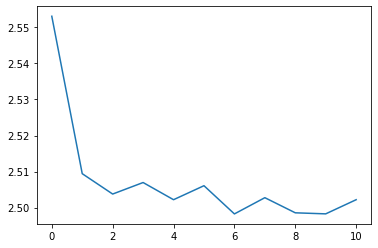

Epoch 1/15
11/11 - 15s - loss: 2.6321 - accuracy: 0.4371 - auc_67: 0.7290 - precision_67: 0.0000e+00 - recall_67: 0.0000e+00 - f1_score: 0.1902 - val_loss: 1.3454 - val_accuracy: 0.5314 - val_auc_67: 0.8095 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.1735 - 15s/epoch - 1s/step
Epoch 2/15
11/11 - 0s - loss: 2.6164 - accuracy: 0.5257 - auc_67: 0.8033 - precision_67: 0.0000e+00 - recall_67: 0.0000e+00 - f1_score: 0.1723 - val_loss: 1.3492 - val_accuracy: 0.5314 - val_auc_67: 0.8095 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.1735 - 389ms/epoch - 35ms/step
Epoch 3/15
11/11 - 0s - loss: 2.6085 - accuracy: 0.4171 - auc_67: 0.7777 - precision_67: 0.0000e+00 - recall_67: 0.0000e+00 - f1_score: 0.2061 - val_loss: 1.3362 - val_accuracy: 0.5314 - val_auc_67: 0.7829 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.1735 - 379ms/epoch - 34ms/step
Epoch 4/15
11/11 - 0s - loss: 2.6229 - accuracy: 0.5257 - auc

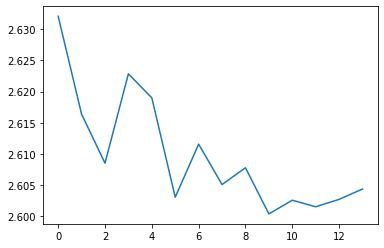

Epoch 1/15
11/11 - 17s - loss: 3.2582 - accuracy: 0.3829 - auc_68: 0.5860 - precision_68: 0.0000e+00 - recall_68: 0.0000e+00 - f1_score: 0.1399 - val_loss: 1.3908 - val_accuracy: 0.3314 - val_auc_68: 0.5771 - val_precision_68: 0.0000e+00 - val_recall_68: 0.0000e+00 - val_f1_score: 0.1245 - 17s/epoch - 2s/step
Epoch 2/15
11/11 - 0s - loss: 3.2206 - accuracy: 0.3314 - auc_68: 0.4656 - precision_68: 0.0000e+00 - recall_68: 0.0000e+00 - f1_score: 0.1774 - val_loss: 1.4248 - val_accuracy: 0.0686 - val_auc_68: 0.2874 - val_precision_68: 0.0000e+00 - val_recall_68: 0.0000e+00 - val_f1_score: 0.0321 - 384ms/epoch - 35ms/step
Epoch 3/15
11/11 - 0s - loss: 3.2107 - accuracy: 0.1057 - auc_68: 0.2826 - precision_68: 0.0000e+00 - recall_68: 0.0000e+00 - f1_score: 0.0478 - val_loss: 1.4283 - val_accuracy: 0.0686 - val_auc_68: 0.2343 - val_precision_68: 0.0000e+00 - val_recall_68: 0.0000e+00 - val_f1_score: 0.0321 - 396ms/epoch - 36ms/step
Epoch 4/15
11/11 - 0s - loss: 3.1792 - accuracy: 0.0429 - auc

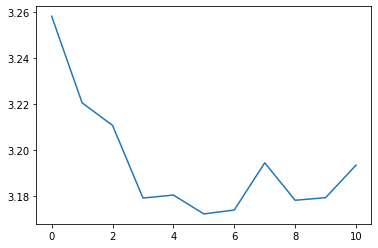

In [27]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(full_body_X):
                            X_train, X_val = full_body_X[train_index], full_body_X[val_index]
                            y_train, y_val = full_body_y[train_index], full_body_y[val_index]
                            body_CNN = build_CNN(body_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(body_CNN, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > body_best_cnn_acc) and (history['val_roc_auc'] > body_best_cnn_auc):
                                body_best_cnn_acc = history['val_accuracy']
                                body_best_cnn_auc = history['val_roc_auc']
                                body_cnn_loss = history['loss']
                                body_best_cnn_model = body_CNN
                                body_cnn_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

#### Train ConvLSTM

In [ ]:
body_best_lstm_acc = 0.0
body_best_lstm_auc = 0.0
body_lstm_loss = float("inf")
body_best_lstm_model = None
body_lstm_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 23s - loss: 22.7262 - accuracy: 0.3714 - auc_69: 0.6618 - precision_69: 0.3709 - recall_69: 0.3571 - f1_score: 0.2304 - val_loss: 1.3858 - val_accuracy: 0.4343 - val_auc_69: 0.7305 - val_precision_69: 0.4435 - val_recall_69: 0.3143 - val_f1_score: 0.2081 - 23s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 4.1000 - accuracy: 0.4286 - auc_69: 0.7142 - precision_69: 0.5493 - recall_69: 0.2229 - f1_score: 0.2724 - val_loss: 1.1888 - val_accuracy: 0.4743 - val_auc_69: 0.7464 - val_precision_69: 0.4930 - val_recall_69: 0.2000 - val_f1_score: 0.2311 - 1s/epoch - 95ms/step
Epoch 3/15
11/11 - 1s - loss: 4.4581 - accuracy: 0.4457 - auc_69: 0.7543 - precision_69: 0.5631 - recall_69: 0.1657 - f1_score: 0.2665 - val_loss: 1.3006 - val_accuracy: 0.2514 - val_auc_69: 0.5747 - val_precision_69: 0.4783 - val_recall_69: 0.0629 - val_f1_score: 0.1816 - 1s/epoch - 96ms/step
Epoch 4/15
11/11 - 1s - loss: 2.4849 - accuracy: 0.3457 - auc_69: 0.7077 - precision_69: 0.5408 - recall_69: 0.151

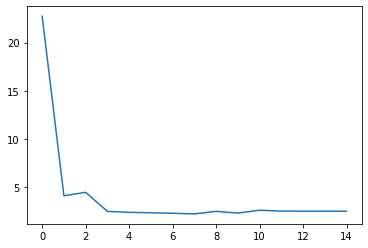

Epoch 1/15
11/11 - 25s - loss: 7.5232 - accuracy: 0.3114 - auc_70: 0.5950 - precision_70: 0.3304 - recall_70: 0.2114 - f1_score: 0.2076 - val_loss: 1.3661 - val_accuracy: 0.1086 - val_auc_70: 0.5941 - val_precision_70: 0.6667 - val_recall_70: 0.0114 - val_f1_score: 0.0583 - 25s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 2.6381 - accuracy: 0.1086 - auc_70: 0.5094 - precision_70: 0.5000 - recall_70: 0.0114 - f1_score: 0.0599 - val_loss: 1.3714 - val_accuracy: 0.1143 - val_auc_70: 0.4127 - val_precision_70: 1.0000 - val_recall_70: 0.0114 - val_f1_score: 0.0661 - 1s/epoch - 98ms/step
Epoch 3/15
11/11 - 1s - loss: 2.6221 - accuracy: 0.1171 - auc_70: 0.6243 - precision_70: 0.8571 - recall_70: 0.0171 - f1_score: 0.0684 - val_loss: 1.3871 - val_accuracy: 0.1086 - val_auc_70: 0.6475 - val_precision_70: 0.7500 - val_recall_70: 0.0171 - val_f1_score: 0.0609 - 1s/epoch - 98ms/step
Epoch 4/15
11/11 - 1s - loss: 2.6476 - accuracy: 0.1314 - auc_70: 0.6593 - precision_70: 0.4667 - recall_70: 0.0200

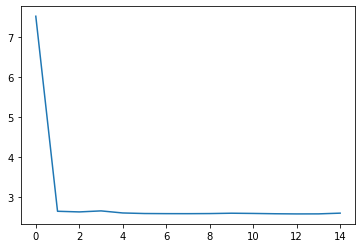

Epoch 1/15
11/11 - 25s - loss: 48.4829 - accuracy: 0.3000 - auc_71: 0.5250 - precision_71: 0.2991 - recall_71: 0.2914 - f1_score: 0.2352 - val_loss: 1.8919 - val_accuracy: 0.3771 - val_auc_71: 0.6863 - val_precision_71: 0.3882 - val_recall_71: 0.3371 - val_f1_score: 0.1980 - 25s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 6.4453 - accuracy: 0.2771 - auc_71: 0.5738 - precision_71: 0.2795 - recall_71: 0.2371 - f1_score: 0.2113 - val_loss: 0.9522 - val_accuracy: 0.6000 - val_auc_71: 0.8400 - val_precision_71: 0.6026 - val_recall_71: 0.5371 - val_f1_score: 0.2713 - 1s/epoch - 103ms/step
Epoch 3/15
11/11 - 1s - loss: 6.3836 - accuracy: 0.3000 - auc_71: 0.6461 - precision_71: 0.3151 - recall_71: 0.2629 - f1_score: 0.2081 - val_loss: 1.7372 - val_accuracy: 0.1314 - val_auc_71: 0.5375 - val_precision_71: 0.1298 - val_recall_71: 0.0971 - val_f1_score: 0.0860 - 1s/epoch - 103ms/step
Epoch 4/15
11/11 - 1s - loss: 3.9033 - accuracy: 0.2600 - auc_71: 0.5683 - precision_71: 0.4272 - recall_71: 0.1

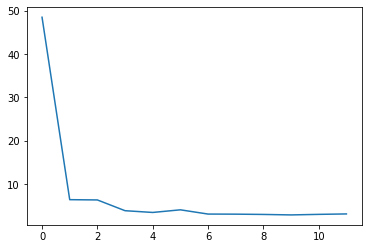

In [28]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(full_body_X):
                            X_train, X_val = full_body_X[train_index], full_body_X[val_index]
                            y_train, y_val = full_body_y[train_index], full_body_y[val_index]
                            body_convLSTM = build_convLSTM(body_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(body_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > body_best_lstm_acc) and (history['val_roc_auc'] > body_best_lstm_auc):
                                body_best_lstm_acc = history['val_accuracy']
                                body_best_lstm_auc = history['val_roc_auc']
                                body_lstm_loss = history['loss']
                                body_best_lstm_model = body_convLSTM
                                body_lstm_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

#### Train RCNN

In [ ]:
body_best_rcnn_acc = 0.0
body_best_rcnn_auc = 0.0
body_rcnn_loss = float("inf")
body_best_rcnn_model = None
body_rcnn_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 8s - loss: 67.7453 - accuracy: 0.3600 - auc_72: 0.5954 - precision_72: 0.3594 - recall_72: 0.3543 - f1_score: 0.2404 - val_loss: 108.9195 - val_accuracy: 0.1200 - val_auc_72: 0.4133 - val_precision_72: 0.1200 - val_recall_72: 0.1200 - val_f1_score: 0.0536 - 8s/epoch - 704ms/step
Epoch 2/15
11/11 - 0s - loss: 62.5873 - accuracy: 0.4257 - auc_72: 0.6584 - precision_72: 0.4265 - recall_72: 0.4229 - f1_score: 0.2860 - val_loss: 56.9569 - val_accuracy: 0.4514 - val_auc_72: 0.6343 - val_precision_72: 0.4514 - val_recall_72: 0.4514 - val_f1_score: 0.1555 - 333ms/epoch - 30ms/step
Epoch 3/15
11/11 - 0s - loss: 11.3489 - accuracy: 0.3829 - auc_72: 0.6254 - precision_72: 0.3833 - recall_72: 0.3800 - f1_score: 0.2819 - val_loss: 20.5780 - val_accuracy: 0.3714 - val_auc_72: 0.5818 - val_precision_72: 0.3714 - val_recall_72: 0.3714 - val_f1_score: 0.1835 - 364ms/epoch - 33ms/step
Epoch 4/15
11/11 - 0s - loss: 11.1064 - accuracy: 0.3714 - auc_72: 0.6220 - precision_72: 0.3725 - re

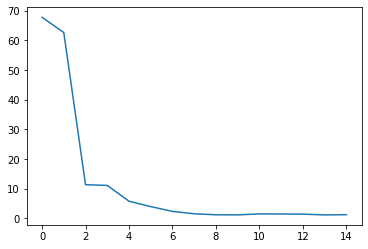

Epoch 1/15
11/11 - 7s - loss: 65.3842 - accuracy: 0.3514 - auc_73: 0.5779 - precision_73: 0.3557 - recall_73: 0.3486 - f1_score: 0.2346 - val_loss: 126.8788 - val_accuracy: 0.5314 - val_auc_73: 0.6876 - val_precision_73: 0.5314 - val_recall_73: 0.5314 - val_f1_score: 0.1735 - 7s/epoch - 654ms/step
Epoch 2/15
11/11 - 0s - loss: 13.8606 - accuracy: 0.3743 - auc_73: 0.6103 - precision_73: 0.3775 - recall_73: 0.3743 - f1_score: 0.2904 - val_loss: 28.3765 - val_accuracy: 0.4743 - val_auc_73: 0.6597 - val_precision_73: 0.4743 - val_recall_73: 0.4743 - val_f1_score: 0.1621 - 359ms/epoch - 33ms/step
Epoch 3/15
11/11 - 0s - loss: 36.8655 - accuracy: 0.3429 - auc_73: 0.6080 - precision_73: 0.3420 - recall_73: 0.3371 - f1_score: 0.2356 - val_loss: 38.1507 - val_accuracy: 0.4400 - val_auc_73: 0.6263 - val_precision_73: 0.4400 - val_recall_73: 0.4400 - val_f1_score: 0.1540 - 362ms/epoch - 33ms/step
Epoch 4/15
11/11 - 0s - loss: 7.9378 - accuracy: 0.4286 - auc_73: 0.6856 - precision_73: 0.4290 - rec

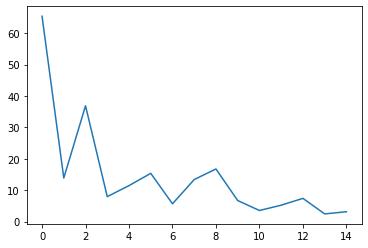

Epoch 1/15
11/11 - 13s - loss: 85.1799 - accuracy: 0.4029 - auc_74: 0.6146 - precision_74: 0.4076 - recall_74: 0.3971 - f1_score: 0.2860 - val_loss: 1113.6249 - val_accuracy: 0.0000e+00 - val_auc_74: 0.3333 - val_precision_74: 0.0000e+00 - val_recall_74: 0.0000e+00 - val_f1_score: 0.0000e+00 - 13s/epoch - 1s/step
Epoch 2/15
11/11 - 0s - loss: 32.2794 - accuracy: 0.3543 - auc_74: 0.5847 - precision_74: 0.3524 - recall_74: 0.3514 - f1_score: 0.2688 - val_loss: 289.8771 - val_accuracy: 0.3314 - val_auc_74: 0.5543 - val_precision_74: 0.3314 - val_recall_74: 0.3314 - val_f1_score: 0.1245 - 316ms/epoch - 29ms/step
Epoch 3/15
11/11 - 0s - loss: 41.5136 - accuracy: 0.3514 - auc_74: 0.5791 - precision_74: 0.3534 - recall_74: 0.3514 - f1_score: 0.2647 - val_loss: 214.8295 - val_accuracy: 0.6000 - val_auc_74: 0.7333 - val_precision_74: 0.6000 - val_recall_74: 0.6000 - val_f1_score: 0.1875 - 315ms/epoch - 29ms/step
Epoch 4/15
11/11 - 0s - loss: 24.9294 - accuracy: 0.4200 - auc_74: 0.6299 - precisi

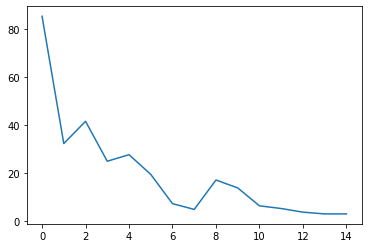

In [29]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(full_body_X):
                            X_train, X_val = full_body_X[train_index], full_body_X[val_index]
                            y_train, y_val = full_body_y[train_index], full_body_y[val_index]
                            body_RCNN = build_RCNN(body_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(body_RCNN, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > body_best_rcnn_acc) and (history['val_roc_auc'] > body_best_rcnn_auc):
                                body_best_rcnn_acc = history['val_accuracy']
                                body_best_rcnn_auc = history['val_roc_auc']
                                body_rcnn_loss = history['loss']
                                body_best_rcnn_model = body_RCNN
                                body_rcnn_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

### 1.2 Face modality (Action units)

In [30]:
umild, lmoderate, lmild, umoderate = np.sum(face_y, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

#### Train BiLSTM

In [ ]:
face_best_biconv_acc = 0.0
face_best_biconv_auc = 0.0
face_biconv_loss = float("inf")
face_best_biconv_model = None
face_biconv_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Kernel size: 3
Epoch 1/15
11/11 - 72s - loss: 3.1986 - accuracy: 0.5015 - auc_75: 0.7039 - precision_75: 0.8750 - recall_75: 0.0206 - f1_score: 0.2050 - val_loss: 1.1691 - val_accuracy: 0.4706 - val_auc_75: 0.7746 - val_precision_75: 0.6429 - val_recall_75: 0.0529 - val_f1_score: 0.1600 - 72s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 3.0017 - accuracy: 0.5015 - auc_75: 0.7250 - precision_75: 0.7000 - recall_75: 0.0413 - f1_score: 0.2921 - val_loss: 1.2841 - val_accuracy: 0.3412 - val_auc_75: 0.6427 - val_precision_75: 0.5085 - val_recall_75: 0.1765 - val_f1_score: 0.1862 - 3s/epoch - 230ms/step
Epoch 3/15
11/11 - 2s - loss: 2.8833 - accuracy: 0.3451 - auc_75: 0.6862 - precision_75: 0.7857 - recall_75: 0.0649 - f1_score: 0.2024 - val_loss: 1.2214 - val_accuracy: 0.2294 - val_auc_75: 0.6595 - val_precision_75: 0.0000e+00 - val_recall_75: 0.0000e+00 - val_f1_score: 0.1791 - 2s/epoch - 227ms/step
Epoch 4/15
11/11 - 3s - loss: 2.8582 - accuracy: 0.3156 - auc_75: 0.6568 - precision_75: 0

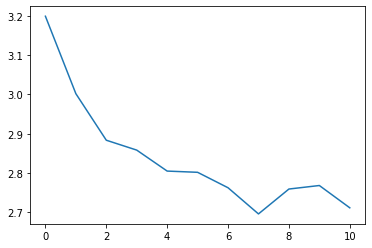

Epoch 1/15
11/11 - 66s - loss: 3.7414 - accuracy: 0.3923 - auc_76: 0.6615 - precision_76: 0.3333 - recall_76: 0.0059 - f1_score: 0.2482 - val_loss: 1.2109 - val_accuracy: 0.0941 - val_auc_76: 0.5879 - val_precision_76: 0.0000e+00 - val_recall_76: 0.0000e+00 - val_f1_score: 0.0430 - 66s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.5951 - accuracy: 0.1593 - auc_76: 0.5979 - precision_76: 0.0000e+00 - recall_76: 0.0000e+00 - f1_score: 0.1116 - val_loss: 1.2819 - val_accuracy: 0.4824 - val_auc_76: 0.7657 - val_precision_76: 0.0000e+00 - val_recall_76: 0.0000e+00 - val_f1_score: 0.2531 - 3s/epoch - 259ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5464 - accuracy: 0.4956 - auc_76: 0.7882 - precision_76: 0.0000e+00 - recall_76: 0.0000e+00 - f1_score: 0.2586 - val_loss: 1.2388 - val_accuracy: 0.5059 - val_auc_76: 0.7901 - val_precision_76: 0.6667 - val_recall_76: 0.0235 - val_f1_score: 0.2590 - 3s/epoch - 256ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4939 - accuracy: 0.4867 - auc_76: 0.7881 - precis

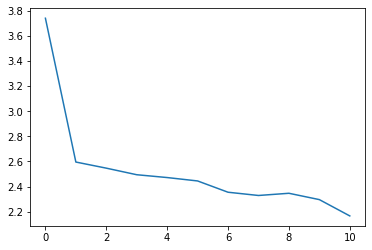

Epoch 1/15
11/11 - 72s - loss: 2.6104 - accuracy: 0.4765 - auc_77: 0.6800 - precision_77: 0.5000 - recall_77: 0.0176 - f1_score: 0.2116 - val_loss: 1.1564 - val_accuracy: 0.5503 - val_auc_77: 0.8206 - val_precision_77: 0.6154 - val_recall_77: 0.0473 - val_f1_score: 0.1775 - 72s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.5984 - accuracy: 0.4912 - auc_77: 0.7611 - precision_77: 0.5000 - recall_77: 0.0059 - f1_score: 0.2079 - val_loss: 1.2240 - val_accuracy: 0.5385 - val_auc_77: 0.7407 - val_precision_77: 0.0000e+00 - val_recall_77: 0.0000e+00 - val_f1_score: 0.2292 - 3s/epoch - 228ms/step
Epoch 3/15
11/11 - 3s - loss: 2.8095 - accuracy: 0.4235 - auc_77: 0.7553 - precision_77: 0.4762 - recall_77: 0.0294 - f1_score: 0.1955 - val_loss: 1.1653 - val_accuracy: 0.2781 - val_auc_77: 0.6721 - val_precision_77: 0.2000 - val_recall_77: 0.0059 - val_f1_score: 0.1286 - 3s/epoch - 258ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4274 - accuracy: 0.2647 - auc_77: 0.6230 - precision_77: 0.0000e+00 - rec

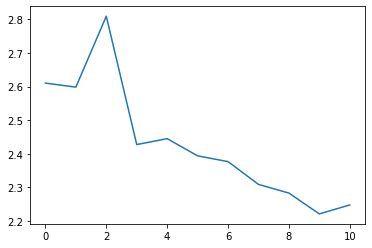

Kernel size: 5
Epoch 1/15
11/11 - 68s - loss: 3.3788 - accuracy: 0.3186 - auc_78: 0.6360 - precision_78: 0.3636 - recall_78: 0.0236 - f1_score: 0.2127 - val_loss: 1.2613 - val_accuracy: 0.1000 - val_auc_78: 0.5586 - val_precision_78: 0.0000e+00 - val_recall_78: 0.0000e+00 - val_f1_score: 0.0455 - 68s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.1641 - accuracy: 0.2507 - auc_78: 0.6215 - precision_78: 0.0000e+00 - recall_78: 0.0000e+00 - f1_score: 0.1441 - val_loss: 1.3579 - val_accuracy: 0.4294 - val_auc_78: 0.6362 - val_precision_78: 0.0000e+00 - val_recall_78: 0.0000e+00 - val_f1_score: 0.1508 - 3s/epoch - 258ms/step
Epoch 3/15
11/11 - 3s - loss: 3.0253 - accuracy: 0.3009 - auc_78: 0.6583 - precision_78: 0.0769 - recall_78: 0.0029 - f1_score: 0.1941 - val_loss: 1.2763 - val_accuracy: 0.2294 - val_auc_78: 0.6450 - val_precision_78: 0.0000e+00 - val_recall_78: 0.0000e+00 - val_f1_score: 0.1574 - 3s/epoch - 251ms/step
Epoch 4/15
11/11 - 3s - loss: 2.9240 - accuracy: 0.1298 - auc_78: 

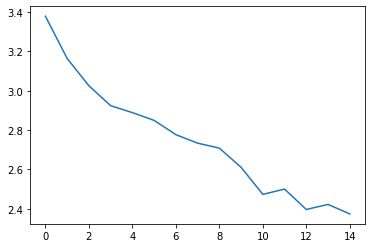

Epoch 1/15
11/11 - 78s - loss: 2.5345 - accuracy: 0.4484 - auc_79: 0.7255 - precision_79: 0.4000 - recall_79: 0.0177 - f1_score: 0.1943 - val_loss: 1.1112 - val_accuracy: 0.3353 - val_auc_79: 0.7701 - val_precision_79: 0.1538 - val_recall_79: 0.0235 - val_f1_score: 0.1333 - 78s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.7789 - accuracy: 0.4307 - auc_79: 0.7737 - precision_79: 0.4286 - recall_79: 0.0265 - f1_score: 0.1919 - val_loss: 1.2340 - val_accuracy: 0.0941 - val_auc_79: 0.5761 - val_precision_79: 0.0000e+00 - val_recall_79: 0.0000e+00 - val_f1_score: 0.0430 - 3s/epoch - 248ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5862 - accuracy: 0.0944 - auc_79: 0.5723 - precision_79: 0.0000e+00 - recall_79: 0.0000e+00 - f1_score: 0.0431 - val_loss: 1.3163 - val_accuracy: 0.0941 - val_auc_79: 0.5518 - val_precision_79: 0.0000e+00 - val_recall_79: 0.0000e+00 - val_f1_score: 0.0430 - 3s/epoch - 248ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5246 - accuracy: 0.1681 - auc_79: 0.6163 - precision_79: 

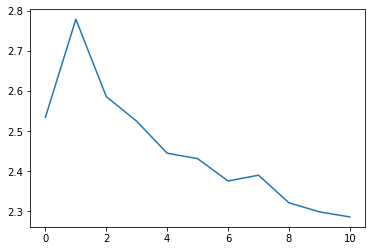

Epoch 1/15
11/11 - 68s - loss: 2.6443 - accuracy: 0.3588 - auc_80: 0.6565 - precision_80: 0.3333 - recall_80: 0.0088 - f1_score: 0.2227 - val_loss: 1.3305 - val_accuracy: 0.0888 - val_auc_80: 0.5229 - val_precision_80: 0.0000e+00 - val_recall_80: 0.0000e+00 - val_f1_score: 0.0408 - 68s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.4992 - accuracy: 0.2118 - auc_80: 0.6232 - precision_80: 0.2692 - recall_80: 0.0206 - f1_score: 0.1347 - val_loss: 1.0841 - val_accuracy: 0.5503 - val_auc_80: 0.7976 - val_precision_80: 0.6667 - val_recall_80: 0.2604 - val_f1_score: 0.1775 - 3s/epoch - 259ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5316 - accuracy: 0.4471 - auc_80: 0.7573 - precision_80: 0.3846 - recall_80: 0.0441 - f1_score: 0.2280 - val_loss: 1.2601 - val_accuracy: 0.2781 - val_auc_80: 0.6722 - val_precision_80: 0.0000e+00 - val_recall_80: 0.0000e+00 - val_f1_score: 0.2023 - 3s/epoch - 248ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4665 - accuracy: 0.3324 - auc_80: 0.6774 - precision_80: 0.0000e+

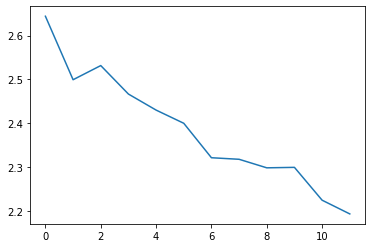

In [31]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(face_X):
                            X_train, X_val = face_X[train_index], face_X[val_index]
                            y_train, y_val = face_y[train_index], face_y[val_index]
                            face_biLSTM = build_biLSTM(face_features, n_length, face_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(face_biLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > face_best_biconv_acc) and (history['val_roc_auc'] > face_best_biconv_auc):
                                face_best_biconv_acc = history['val_accuracy']
                                face_best_biconv_auc = history['val_roc_auc']
                                face_biconv_loss = history['loss']
                                face_best_biconv_model = face_biLSTM
                                face_biconv_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

#### Train CNN+LSTM

In [ ]:
face_best_cnn_acc = 0.0
face_best_cnn_auc = 0.0
face_cnn_loss = float("inf")
face_best_cnn_model = None
face_cnn_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 28s - loss: 3.0934 - accuracy: 0.5457 - auc_141: 0.7845 - precision_141: 0.0000e+00 - recall_141: 0.0000e+00 - f1_score: 0.2132 - val_loss: 1.2754 - val_accuracy: 0.4706 - val_auc_141: 0.7822 - val_precision_141: 0.0000e+00 - val_recall_141: 0.0000e+00 - val_f1_score: 0.1600 - 28s/epoch - 3s/step
Epoch 2/15
11/11 - 0s - loss: 2.9728 - accuracy: 0.5546 - auc_141: 0.8009 - precision_141: 0.0000e+00 - recall_141: 0.0000e+00 - f1_score: 0.1784 - val_loss: 1.2406 - val_accuracy: 0.4706 - val_auc_141: 0.7444 - val_precision_141: 0.0000e+00 - val_recall_141: 0.0000e+00 - val_f1_score: 0.1600 - 398ms/epoch - 36ms/step
Epoch 3/15
11/11 - 0s - loss: 2.8902 - accuracy: 0.4513 - auc_141: 0.7547 - precision_141: 0.0000e+00 - recall_141: 0.0000e+00 - f1_score: 0.1752 - val_loss: 1.1881 - val_accuracy: 0.4706 - val_auc_141: 0.7425 - val_precision_141: 0.0000e+00 - val_recall_141: 0.0000e+00 - val_f1_score: 0.1600 - 391ms/epoch - 36ms/step
Epoch 4/15
11/11 - 0s - loss: 2.8450 - accu

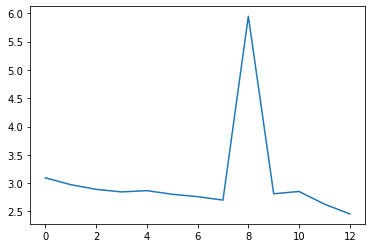

Epoch 1/15
11/11 - 16s - loss: 2.5142 - accuracy: 0.4838 - auc_142: 0.7160 - precision_142: 0.0000e+00 - recall_142: 0.0000e+00 - f1_score: 0.1945 - val_loss: 1.1199 - val_accuracy: 0.5588 - val_auc_142: 0.8263 - val_precision_142: 0.0000e+00 - val_recall_142: 0.0000e+00 - val_f1_score: 0.1792 - 16s/epoch - 1s/step
Epoch 2/15
11/11 - 0s - loss: 3.2970 - accuracy: 0.4513 - auc_142: 0.7737 - precision_142: 0.0000e+00 - recall_142: 0.0000e+00 - f1_score: 0.2372 - val_loss: 1.1312 - val_accuracy: 0.3412 - val_auc_142: 0.7442 - val_precision_142: 0.0000e+00 - val_recall_142: 0.0000e+00 - val_f1_score: 0.1272 - 402ms/epoch - 37ms/step
Epoch 3/15
11/11 - 0s - loss: 2.8051 - accuracy: 0.3422 - auc_142: 0.6872 - precision_142: 0.0000e+00 - recall_142: 0.0000e+00 - f1_score: 0.1405 - val_loss: 1.2008 - val_accuracy: 0.3294 - val_auc_142: 0.5647 - val_precision_142: 0.0000e+00 - val_recall_142: 0.0000e+00 - val_f1_score: 0.1279 - 415ms/epoch - 38ms/step
Epoch 4/15
11/11 - 0s - loss: 2.6676 - accu

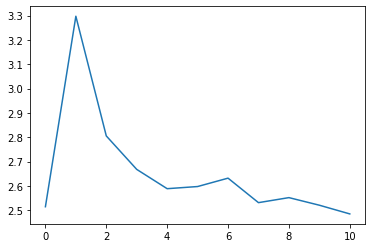

Epoch 1/15
11/11 - 18s - loss: 2.4396 - accuracy: 0.4059 - auc_143: 0.7225 - precision_143: 0.0000e+00 - recall_143: 0.0000e+00 - f1_score: 0.2717 - val_loss: 1.1111 - val_accuracy: 0.5503 - val_auc_143: 0.8272 - val_precision_143: 0.0000e+00 - val_recall_143: 0.0000e+00 - val_f1_score: 0.1775 - 18s/epoch - 2s/step
Epoch 2/15
11/11 - 0s - loss: 3.1232 - accuracy: 0.2971 - auc_143: 0.6381 - precision_143: 0.0000e+00 - recall_143: 0.0000e+00 - f1_score: 0.1775 - val_loss: 1.2187 - val_accuracy: 0.0888 - val_auc_143: 0.5107 - val_precision_143: 0.0000e+00 - val_recall_143: 0.0000e+00 - val_f1_score: 0.0408 - 420ms/epoch - 38ms/step
Epoch 3/15
11/11 - 0s - loss: 2.7368 - accuracy: 0.0971 - auc_143: 0.5278 - precision_143: 0.0000e+00 - recall_143: 0.0000e+00 - f1_score: 0.0442 - val_loss: 1.2620 - val_accuracy: 0.0888 - val_auc_143: 0.5208 - val_precision_143: 0.0000e+00 - val_recall_143: 0.0000e+00 - val_f1_score: 0.0408 - 423ms/epoch - 38ms/step
Epoch 4/15
11/11 - 0s - loss: 2.6194 - accu

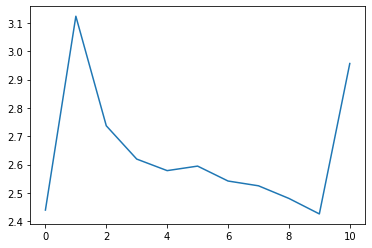

In [38]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(face_X):
                            X_train, X_val = face_X[train_index], face_X[val_index]
                            y_train, y_val = face_y[train_index], face_y[val_index]
                            face_CNN = build_CNN(face_features, n_length, face_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(face_CNN, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > face_best_cnn_acc) and (history['val_roc_auc'] > face_best_cnn_auc):
                                face_best_cnn_acc = history['val_accuracy']
                                face_best_cnn_auc = history['val_roc_auc']
                                face_cnn_loss = history['loss']
                                face_best_cnn_model = face_CNN
                                face_cnn_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

#### Train ConvLSTM

In [ ]:
face_best_lstm_acc = 0.0
face_best_lstm_auc = 0.0
face_lstm_loss = float("inf")
face_best_lstm_model = None
face_lstm_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 23s - loss: 3.0544 - accuracy: 0.5221 - auc_144: 0.6810 - precision_144: 0.6471 - recall_144: 0.0324 - f1_score: 0.2299 - val_loss: 1.2702 - val_accuracy: 0.3412 - val_auc_144: 0.6497 - val_precision_144: 0.5926 - val_recall_144: 0.0941 - val_f1_score: 0.1854 - 23s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 2.9286 - accuracy: 0.3894 - auc_144: 0.6883 - precision_144: 0.5714 - recall_144: 0.0236 - f1_score: 0.2172 - val_loss: 1.2429 - val_accuracy: 0.3412 - val_auc_144: 0.6370 - val_precision_144: 0.5143 - val_recall_144: 0.1059 - val_f1_score: 0.1908 - 1s/epoch - 96ms/step
Epoch 3/15
11/11 - 1s - loss: 2.8675 - accuracy: 0.4366 - auc_144: 0.7072 - precision_144: 0.6724 - recall_144: 0.1150 - f1_score: 0.2564 - val_loss: 1.2222 - val_accuracy: 0.2765 - val_auc_144: 0.6765 - val_precision_144: 0.0000e+00 - val_recall_144: 0.0000e+00 - val_f1_score: 0.1906 - 1s/epoch - 97ms/step
Epoch 4/15
11/11 - 1s - loss: 2.8382 - accuracy: 0.3127 - auc_144: 0.6945 - precision_144

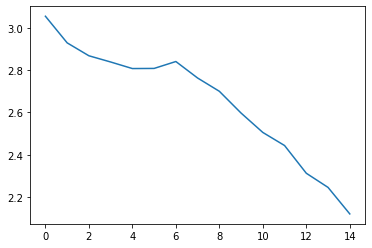

Epoch 1/15
11/11 - 26s - loss: 2.5801 - accuracy: 0.3776 - auc_145: 0.7452 - precision_145: 0.0000e+00 - recall_145: 0.0000e+00 - f1_score: 0.2191 - val_loss: 1.2055 - val_accuracy: 0.5588 - val_auc_145: 0.7976 - val_precision_145: 0.6667 - val_recall_145: 0.0235 - val_f1_score: 0.1792 - 26s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 2.4622 - accuracy: 0.4572 - auc_145: 0.7658 - precision_145: 0.5833 - recall_145: 0.0206 - f1_score: 0.2377 - val_loss: 1.2112 - val_accuracy: 0.3529 - val_auc_145: 0.6951 - val_precision_145: 1.0000 - val_recall_145: 0.0059 - val_f1_score: 0.2000 - 1s/epoch - 107ms/step
Epoch 3/15
11/11 - 1s - loss: 2.4254 - accuracy: 0.2655 - auc_145: 0.6627 - precision_145: 0.4000 - recall_145: 0.0177 - f1_score: 0.1881 - val_loss: 1.2938 - val_accuracy: 0.1529 - val_auc_145: 0.6030 - val_precision_145: 0.1250 - val_recall_145: 0.0059 - val_f1_score: 0.1124 - 1s/epoch - 109ms/step
Epoch 4/15
11/11 - 1s - loss: 2.3668 - accuracy: 0.2861 - auc_145: 0.6992 - precision_1

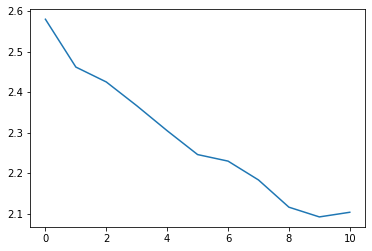

Epoch 1/15
11/11 - 27s - loss: 2.5579 - accuracy: 0.3294 - auc_146: 0.6438 - precision_146: 0.3333 - recall_146: 0.0059 - f1_score: 0.2195 - val_loss: 1.1742 - val_accuracy: 0.5503 - val_auc_146: 0.7319 - val_precision_146: 0.6875 - val_recall_146: 0.0651 - val_f1_score: 0.1775 - 27s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 2.5071 - accuracy: 0.5088 - auc_146: 0.7187 - precision_146: 0.8182 - recall_146: 0.0265 - f1_score: 0.2627 - val_loss: 1.2286 - val_accuracy: 0.3550 - val_auc_146: 0.6412 - val_precision_146: 0.0000e+00 - val_recall_146: 0.0000e+00 - val_f1_score: 0.1310 - 1s/epoch - 101ms/step
Epoch 3/15
11/11 - 1s - loss: 2.5441 - accuracy: 0.4265 - auc_146: 0.6922 - precision_146: 0.6667 - recall_146: 0.0353 - f1_score: 0.2679 - val_loss: 1.2492 - val_accuracy: 0.2781 - val_auc_146: 0.5885 - val_precision_146: 0.0000e+00 - val_recall_146: 0.0000e+00 - val_f1_score: 0.1278 - 1s/epoch - 98ms/step
Epoch 4/15
11/11 - 1s - loss: 2.4641 - accuracy: 0.4176 - auc_146: 0.6718 - prec

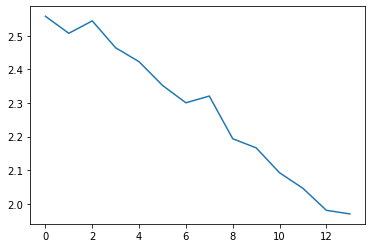

In [39]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(face_X):
                            X_train, X_val = face_X[train_index], face_X[val_index]
                            y_train, y_val = face_y[train_index], face_y[val_index]
                            face_convLSTM = build_convLSTM(face_features, n_length, face_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(face_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > face_best_lstm_acc) and (history['val_roc_auc'] > face_best_lstm_auc):
                                face_best_lstm_acc = history['val_accuracy']
                                face_best_lstm_auc = history['val_roc_auc']
                                face_lstm_loss = history['loss']
                                face_best_lstm_model = face_convLSTM
                                face_lstm_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

#### Train RCNN

In [ ]:
face_best_rcnn_acc = 0.0
face_best_rcnn_auc = 0.0
face_rcnn_loss = float("inf")
face_best_rcnn_model = None
face_rcnn_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 7s - loss: 52.9261 - accuracy: 0.2684 - auc_147: 0.5051 - precision_147: 0.2586 - recall_147: 0.2448 - f1_score: 0.2134 - val_loss: 1.5916 - val_accuracy: 0.1941 - val_auc_147: 0.5027 - val_precision_147: 0.4030 - val_recall_147: 0.1588 - val_f1_score: 0.1267 - 7s/epoch - 667ms/step
Epoch 2/15
11/11 - 0s - loss: 9.7540 - accuracy: 0.3068 - auc_147: 0.5992 - precision_147: 0.3086 - recall_147: 0.3068 - f1_score: 0.2351 - val_loss: 1.5767 - val_accuracy: 0.3059 - val_auc_147: 0.5619 - val_precision_147: 0.0323 - val_recall_147: 0.0059 - val_f1_score: 0.1618 - 360ms/epoch - 33ms/step
Epoch 3/15
11/11 - 0s - loss: 18.7056 - accuracy: 0.4543 - auc_147: 0.6797 - precision_147: 0.4551 - recall_147: 0.4484 - f1_score: 0.3339 - val_loss: 1.2896 - val_accuracy: 0.3824 - val_auc_147: 0.6799 - val_precision_147: 0.1212 - val_recall_147: 0.0235 - val_f1_score: 0.1752 - 343ms/epoch - 31ms/step
Epoch 4/15
11/11 - 0s - loss: 27.9410 - accuracy: 0.2566 - auc_147: 0.5640 - precision_1

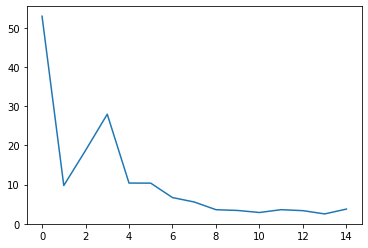

Epoch 1/15
11/11 - 8s - loss: 51.2040 - accuracy: 0.2891 - auc_148: 0.5098 - precision_148: 0.2972 - recall_148: 0.2832 - f1_score: 0.2235 - val_loss: 1.8891 - val_accuracy: 0.3882 - val_auc_148: 0.6838 - val_precision_148: 0.4051 - val_recall_148: 0.1882 - val_f1_score: 0.1879 - 8s/epoch - 704ms/step
Epoch 2/15
11/11 - 0s - loss: 32.7435 - accuracy: 0.3038 - auc_148: 0.5350 - precision_148: 0.3056 - recall_148: 0.3038 - f1_score: 0.2217 - val_loss: 1.5217 - val_accuracy: 0.3471 - val_auc_148: 0.6365 - val_precision_148: 0.6143 - val_recall_148: 0.2529 - val_f1_score: 0.2318 - 362ms/epoch - 33ms/step
Epoch 3/15
11/11 - 0s - loss: 9.7693 - accuracy: 0.4041 - auc_148: 0.6849 - precision_148: 0.4012 - recall_148: 0.3835 - f1_score: 0.2809 - val_loss: 1.9883 - val_accuracy: 0.1706 - val_auc_148: 0.4875 - val_precision_148: 0.1479 - val_recall_148: 0.1235 - val_f1_score: 0.1310 - 341ms/epoch - 31ms/step
Epoch 4/15
11/11 - 0s - loss: 9.6385 - accuracy: 0.3068 - auc_148: 0.6245 - precision_14

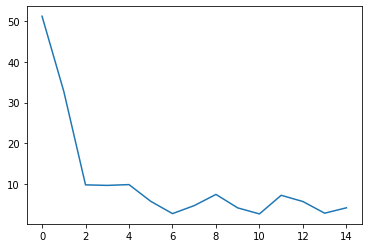

Epoch 1/15
11/11 - 8s - loss: 47.3937 - accuracy: 0.3088 - auc_149: 0.5581 - precision_149: 0.3114 - recall_149: 0.3059 - f1_score: 0.2217 - val_loss: 2.2028 - val_accuracy: 0.4793 - val_auc_149: 0.6875 - val_precision_149: 0.5870 - val_recall_149: 0.3195 - val_f1_score: 0.2447 - 8s/epoch - 707ms/step
Epoch 2/15
11/11 - 0s - loss: 20.1115 - accuracy: 0.2294 - auc_149: 0.4963 - precision_149: 0.2308 - recall_149: 0.2294 - f1_score: 0.1905 - val_loss: 1.6402 - val_accuracy: 0.2426 - val_auc_149: 0.5745 - val_precision_149: 0.2037 - val_recall_149: 0.0651 - val_f1_score: 0.1944 - 387ms/epoch - 35ms/step
Epoch 3/15
11/11 - 0s - loss: 15.2895 - accuracy: 0.3706 - auc_149: 0.6605 - precision_149: 0.3687 - recall_149: 0.3676 - f1_score: 0.2847 - val_loss: 1.6131 - val_accuracy: 0.1302 - val_auc_149: 0.5059 - val_precision_149: 0.2593 - val_recall_149: 0.0414 - val_f1_score: 0.1197 - 354ms/epoch - 32ms/step
Epoch 4/15
11/11 - 0s - loss: 3.7041 - accuracy: 0.4647 - auc_149: 0.7459 - precision_1

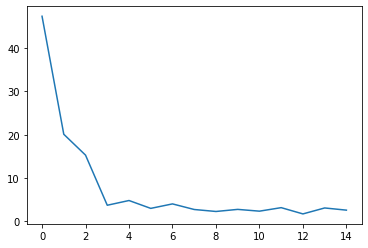

In [40]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(face_X):
                            X_train, X_val = face_X[train_index], face_X[val_index]
                            y_train, y_val = face_y[train_index], face_y[val_index]
                            face_RCNN = build_RCNN(face_features, n_length, face_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(face_RCNN, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > face_best_rcnn_acc) and (history['val_roc_auc'] > face_best_rcnn_auc):
                                face_best_rcnn_acc = history['val_accuracy']
                                face_best_rcnn_auc = history['val_roc_auc']
                                face_rcnn_loss = history['loss']
                                face_best_rcnn_model = face_RCNN
                                face_rcnn_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

## 2. Early Fusion - Fusion is performed at feature level

Early fusion concatenates features at the input level, then all the work is on the classifier. 

My initial assumption is that perhaps early fusion is not the best idea because the face modality is missing about half the times (OpenFace could not capture facial action units from the videos), which makes the dataset smaller. 
I did not replace the missing facial values because I thought null values will bring no benefit (I assume?) and adding for example zero would mean the absence of action units which I'm afraid might actually "trick" the model in the case where a person has pain and the facial modality was not available because of technical issues, not because of an actual lack of pain.

### About the data

In [41]:
early_X_train, early_X_test, early_y_train, early_y_test = load_earlyfusion_dataset('processed')
early_X = early_X_train.copy()
early_y = early_y_train.copy()

print(early_X_train.shape, early_y_train.shape)
print(early_X_test.shape, early_y_test.shape)

n_length, early_features, early_outputs = early_X_train.shape[2], early_X_train.shape[-1], early_y_train.shape[1]

(509, 1, 350, 48) (509, 4)
(88, 1, 350, 48) (88, 4)


In [43]:
umild, lmoderate, lmild, umoderate = np.sum(early_y, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

### Train BiLSTM (with early fusion)

In [ ]:
early_best_biconv_acc = 0.0
early_best_biconv_auc = 0.0
early_biconv_loss = float("inf")
early_best_biconv_model = None
early_biconv_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 73s - loss: 129.5472 - accuracy: 0.3481 - auc_150: 0.5787 - precision_150: 0.3537 - recall_150: 0.3422 - f1_score: 0.2187 - val_loss: 1.5229 - val_accuracy: 0.2824 - val_auc_150: 0.4806 - val_precision_150: 0.6842 - val_recall_150: 0.0765 - val_f1_score: 0.2049 - 73s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 3.7625 - accuracy: 0.2419 - auc_150: 0.4902 - precision_150: 0.2531 - recall_150: 0.1209 - f1_score: 0.1595 - val_loss: 1.3111 - val_accuracy: 0.4353 - val_auc_150: 0.6845 - val_precision_150: 0.5000 - val_recall_150: 0.0059 - val_f1_score: 0.2340 - 3s/epoch - 253ms/step
Epoch 3/15
11/11 - 3s - loss: 3.3652 - accuracy: 0.2330 - auc_150: 0.5892 - precision_150: 0.5238 - recall_150: 0.0324 - f1_score: 0.1412 - val_loss: 1.3885 - val_accuracy: 0.0000e+00 - val_auc_150: 0.3333 - val_precision_150: 0.0000e+00 - val_recall_150: 0.0000e+00 - val_f1_score: 0.0000e+00 - 3s/epoch - 252ms/step
Epoch 4/15
11/11 - 3s - loss: 3.0849 - accuracy: 0.0059 - auc_150: 0.3373 - p

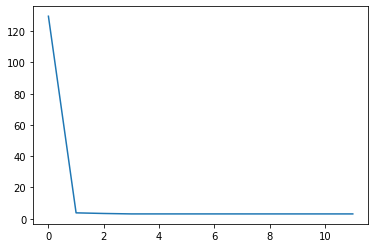

Epoch 1/15
11/11 - 70s - loss: 42.9827 - accuracy: 0.2979 - auc_151: 0.5810 - precision_151: 0.2947 - recall_151: 0.2773 - f1_score: 0.2136 - val_loss: 1.3943 - val_accuracy: 0.5471 - val_auc_151: 0.7801 - val_precision_151: 0.4839 - val_recall_151: 0.0882 - val_f1_score: 0.1843 - 70s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 5.6830 - accuracy: 0.4366 - auc_151: 0.5992 - precision_151: 0.8667 - recall_151: 0.0383 - f1_score: 0.2348 - val_loss: 1.3865 - val_accuracy: 0.3353 - val_auc_151: 0.5020 - val_precision_151: 0.0000e+00 - val_recall_151: 0.0000e+00 - val_f1_score: 0.1256 - 3s/epoch - 266ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5857 - accuracy: 0.3982 - auc_151: 0.5297 - precision_151: 0.5652 - recall_151: 0.0383 - f1_score: 0.1596 - val_loss: 1.3610 - val_accuracy: 0.4235 - val_auc_151: 0.6689 - val_precision_151: 0.6842 - val_recall_151: 0.0765 - val_f1_score: 0.2218 - 3s/epoch - 266ms/step
Epoch 4/15
11/11 - 3s - loss: 2.6642 - accuracy: 0.4336 - auc_151: 0.5721 - precision_

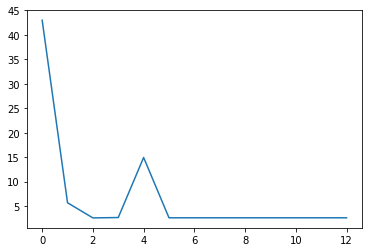

Epoch 1/15
11/11 - 70s - loss: 27.0336 - accuracy: 0.2824 - auc_152: 0.5452 - precision_152: 0.2802 - recall_152: 0.2118 - f1_score: 0.1911 - val_loss: 1.4979 - val_accuracy: 0.1598 - val_auc_152: 0.4516 - val_precision_152: 1.0000 - val_recall_152: 0.0059 - val_f1_score: 0.0999 - 70s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.0681 - accuracy: 0.1353 - auc_152: 0.3979 - precision_152: 0.0333 - recall_152: 0.0029 - f1_score: 0.0938 - val_loss: 1.1209 - val_accuracy: 0.4201 - val_auc_152: 0.7297 - val_precision_152: 0.5000 - val_recall_152: 0.0533 - val_f1_score: 0.2126 - 3s/epoch - 264ms/step
Epoch 3/15
11/11 - 3s - loss: 6.0360 - accuracy: 0.4265 - auc_152: 0.7392 - precision_152: 0.5120 - recall_152: 0.2500 - f1_score: 0.2745 - val_loss: 1.3734 - val_accuracy: 0.4320 - val_auc_152: 0.6618 - val_precision_152: 0.7333 - val_recall_152: 0.0651 - val_f1_score: 0.2545 - 3s/epoch - 263ms/step
Epoch 4/15
11/11 - 3s - loss: 3.2266 - accuracy: 0.2735 - auc_152: 0.3992 - precision_152: 0.0

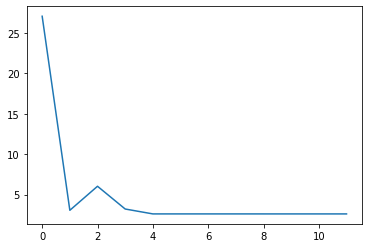

In [44]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(early_X):
                            X_train, X_val = early_X[train_index], early_X[val_index]
                            y_train, y_val = early_y[train_index], early_y[val_index]
                            early_biLSTM = build_biLSTM(early_features, n_length, early_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(early_biLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > early_best_biconv_acc) and (history['val_roc_auc'] > early_best_biconv_auc):
                                early_best_biconv_acc = history['val_accuracy']
                                early_best_biconv_auc = history['val_roc_auc']
                                early_biconv_loss = history['loss']
                                early_best_biconv_model = early_biLSTM
                                early_biconv_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': float("inf") }

### Train CNN+LSTM (with early fusion)

In [ ]:
early_best_cnn_acc = 0.0
early_best_cnn_auc = 0.0
early_cnn_loss = float("inf")
early_best_cnn_model = None
early_cnn_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 31s - loss: 3.1229 - accuracy: 0.5133 - auc_153: 0.6500 - precision_153: 0.0000e+00 - recall_153: 0.0000e+00 - f1_score: 0.1816 - val_loss: 1.3740 - val_accuracy: 0.4706 - val_auc_153: 0.6137 - val_precision_153: 0.0000e+00 - val_recall_153: 0.0000e+00 - val_f1_score: 0.1600 - 31s/epoch - 3s/step
Epoch 2/15
11/11 - 0s - loss: 3.0950 - accuracy: 0.2035 - auc_153: 0.5228 - precision_153: 0.0000e+00 - recall_153: 0.0000e+00 - f1_score: 0.1092 - val_loss: 1.4102 - val_accuracy: 0.0000e+00 - val_auc_153: 0.4020 - val_precision_153: 0.0000e+00 - val_recall_153: 0.0000e+00 - val_f1_score: 0.0000e+00 - 422ms/epoch - 38ms/step
Epoch 3/15
11/11 - 0s - loss: 3.0684 - accuracy: 0.0059 - auc_153: 0.4503 - precision_153: 0.0000e+00 - recall_153: 0.0000e+00 - f1_score: 0.0029 - val_loss: 1.4230 - val_accuracy: 0.0000e+00 - val_auc_153: 0.4020 - val_precision_153: 0.0000e+00 - val_recall_153: 0.0000e+00 - val_f1_score: 0.0000e+00 - 418ms/epoch - 38ms/step
Epoch 4/15
11/11 - 0s - los

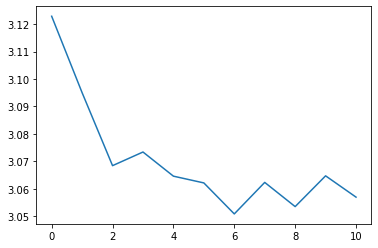

Epoch 1/15
11/11 - 20s - loss: 2.6485 - accuracy: 0.2714 - auc_154: 0.6677 - precision_154: 0.0000e+00 - recall_154: 0.0000e+00 - f1_score: 0.1375 - val_loss: 1.3184 - val_accuracy: 0.3412 - val_auc_154: 0.7451 - val_precision_154: 0.0000e+00 - val_recall_154: 0.0000e+00 - val_f1_score: 0.1272 - 20s/epoch - 2s/step
Epoch 2/15
11/11 - 0s - loss: 2.6188 - accuracy: 0.3923 - auc_154: 0.6762 - precision_154: 0.0000e+00 - recall_154: 0.0000e+00 - f1_score: 0.1409 - val_loss: 1.3276 - val_accuracy: 0.3412 - val_auc_154: 0.5905 - val_precision_154: 0.0000e+00 - val_recall_154: 0.0000e+00 - val_f1_score: 0.1272 - 477ms/epoch - 43ms/step
Epoch 3/15
11/11 - 0s - loss: 2.6127 - accuracy: 0.3923 - auc_154: 0.6687 - precision_154: 0.0000e+00 - recall_154: 0.0000e+00 - f1_score: 0.1409 - val_loss: 1.3077 - val_accuracy: 0.3412 - val_auc_154: 0.7454 - val_precision_154: 0.0000e+00 - val_recall_154: 0.0000e+00 - val_f1_score: 0.1272 - 472ms/epoch - 43ms/step
Epoch 4/15
11/11 - 0s - loss: 2.5917 - accu

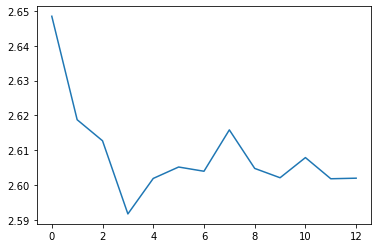

Epoch 1/15
11/11 - 20s - loss: 2.6268 - accuracy: 0.1059 - auc_155: 0.5201 - precision_155: 0.0000e+00 - recall_155: 0.0000e+00 - f1_score: 0.0619 - val_loss: 1.3723 - val_accuracy: 0.0888 - val_auc_155: 0.5740 - val_precision_155: 0.0000e+00 - val_recall_155: 0.0000e+00 - val_f1_score: 0.0408 - 20s/epoch - 2s/step
Epoch 2/15
11/11 - 0s - loss: 2.6200 - accuracy: 0.0971 - auc_155: 0.5549 - precision_155: 0.0000e+00 - recall_155: 0.0000e+00 - f1_score: 0.0442 - val_loss: 1.3701 - val_accuracy: 0.0888 - val_auc_155: 0.5393 - val_precision_155: 0.0000e+00 - val_recall_155: 0.0000e+00 - val_f1_score: 0.0408 - 455ms/epoch - 41ms/step
Epoch 3/15
11/11 - 0s - loss: 2.6466 - accuracy: 0.0971 - auc_155: 0.5459 - precision_155: 0.0000e+00 - recall_155: 0.0000e+00 - f1_score: 0.0442 - val_loss: 1.3381 - val_accuracy: 0.0888 - val_auc_155: 0.5414 - val_precision_155: 0.0000e+00 - val_recall_155: 0.0000e+00 - val_f1_score: 0.0408 - 493ms/epoch - 45ms/step
Epoch 4/15
11/11 - 0s - loss: 2.6340 - accu

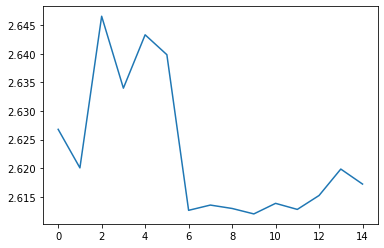

In [45]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(early_X):
                            X_train, X_val = early_X[train_index], early_X[val_index]
                            y_train, y_val = early_y[train_index], early_y[val_index]
                            early_CNN = build_CNN(early_features, n_length, early_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(early_CNN, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > early_best_cnn_acc) and (history['val_roc_auc'] > early_best_cnn_auc):
                                early_best_cnn_acc = history['val_accuracy']
                                early_best_cnn_auc = history['val_roc_auc']
                                early_cnn_loss = history['loss']
                                early_best_cnn_model = early_CNN
                                early_cnn_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': float("inf") }

### Train ConvLSTM (with early fusion)

In [ ]:
early_best_lstm_acc = 0.0
early_best_lstm_auc = 0.0
early_lstm_loss = float("inf")
early_best_lstm_model = None
early_lstm_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 27s - loss: 23.7221 - accuracy: 0.3717 - auc_156: 0.5776 - precision_156: 0.3671 - recall_156: 0.3097 - f1_score: 0.2368 - val_loss: 1.3821 - val_accuracy: 0.2765 - val_auc_156: 0.5602 - val_precision_156: 0.4545 - val_recall_156: 0.0294 - val_f1_score: 0.1684 - 27s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 3.0947 - accuracy: 0.0560 - auc_156: 0.4047 - precision_156: 0.0667 - recall_156: 0.0088 - f1_score: 0.0533 - val_loss: 1.3730 - val_accuracy: 0.0824 - val_auc_156: 0.4238 - val_precision_156: 0.5000 - val_recall_156: 0.0059 - val_f1_score: 0.0785 - 1s/epoch - 105ms/step
Epoch 3/15
11/11 - 1s - loss: 3.1383 - accuracy: 0.1062 - auc_156: 0.4769 - precision_156: 0.7391 - recall_156: 0.0501 - f1_score: 0.0843 - val_loss: 1.4105 - val_accuracy: 0.0059 - val_auc_156: 0.3526 - val_precision_156: 0.3333 - val_recall_156: 0.0059 - val_f1_score: 0.0066 - 1s/epoch - 107ms/step
Epoch 4/15
11/11 - 1s - loss: 3.0541 - accuracy: 0.0324 - auc_156: 0.3687 - precision_156: 1.0

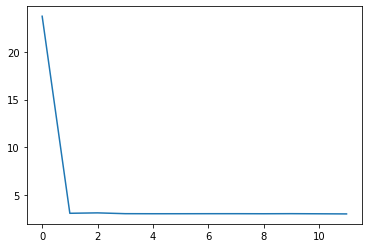

Epoch 1/15
11/11 - 28s - loss: 15.8942 - accuracy: 0.2920 - auc_157: 0.5535 - precision_157: 0.2804 - recall_157: 0.2242 - f1_score: 0.2157 - val_loss: 1.4524 - val_accuracy: 0.2235 - val_auc_157: 0.5631 - val_precision_157: 0.2353 - val_recall_157: 0.0941 - val_f1_score: 0.1584 - 28s/epoch - 3s/step
Epoch 2/15
11/11 - 1s - loss: 4.2482 - accuracy: 0.3894 - auc_157: 0.7171 - precision_157: 0.4407 - recall_157: 0.1534 - f1_score: 0.2632 - val_loss: 1.3544 - val_accuracy: 0.3059 - val_auc_157: 0.6804 - val_precision_157: 0.3717 - val_recall_157: 0.2471 - val_f1_score: 0.1793 - 1s/epoch - 101ms/step
Epoch 3/15
11/11 - 1s - loss: 2.9542 - accuracy: 0.3009 - auc_157: 0.6296 - precision_157: 0.2721 - recall_157: 0.1180 - f1_score: 0.2232 - val_loss: 1.3203 - val_accuracy: 0.1824 - val_auc_157: 0.5714 - val_precision_157: 0.4000 - val_recall_157: 0.0118 - val_f1_score: 0.1489 - 1s/epoch - 102ms/step
Epoch 4/15
11/11 - 1s - loss: 2.4175 - accuracy: 0.3746 - auc_157: 0.7221 - precision_157: 0.5

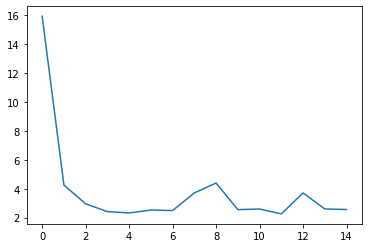

Epoch 1/15
11/11 - 26s - loss: 60.2137 - accuracy: 0.2882 - auc_158: 0.5207 - precision_158: 0.2936 - recall_158: 0.2824 - f1_score: 0.2178 - val_loss: 1.3367 - val_accuracy: 0.3254 - val_auc_158: 0.6807 - val_precision_158: 0.3462 - val_recall_158: 0.2130 - val_f1_score: 0.2189 - 26s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 5.9621 - accuracy: 0.4059 - auc_158: 0.7013 - precision_158: 0.3908 - recall_158: 0.2735 - f1_score: 0.2670 - val_loss: 2.4304 - val_accuracy: 0.3905 - val_auc_158: 0.7001 - val_precision_158: 0.5849 - val_recall_158: 0.1834 - val_f1_score: 0.2461 - 1s/epoch - 108ms/step
Epoch 3/15
11/11 - 1s - loss: 3.5791 - accuracy: 0.1853 - auc_158: 0.5111 - precision_158: 0.6250 - recall_158: 0.0441 - f1_score: 0.1315 - val_loss: 1.3844 - val_accuracy: 0.2308 - val_auc_158: 0.6060 - val_precision_158: 0.3864 - val_recall_158: 0.1006 - val_f1_score: 0.1662 - 1s/epoch - 104ms/step
Epoch 4/15
11/11 - 1s - loss: 2.8113 - accuracy: 0.1618 - auc_158: 0.4771 - precision_158: 0.5

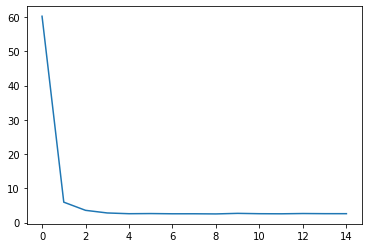

In [46]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(early_X):
                            X_train, X_val = early_X[train_index], early_X[val_index]
                            y_train, y_val = early_y[train_index], early_y[val_index]
                            early_convLSTM = build_convLSTM(early_features, n_length, early_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(early_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > early_best_lstm_acc) and (history['val_roc_auc'] > early_best_lstm_auc):
                                early_best_lstm_acc = history['val_accuracy']
                                early_best_lstm_auc = history['val_roc_auc']
                                early_lstm_loss = history['loss']
                                early_best_lstm_model = early_convLSTM
                                early_lstm_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': float("inf") }

### Train RCNN (with early fusion)

In [ ]:
early_best_rcnn_acc = 0.0
early_best_rcnn_auc = 0.0
early_rcnn_loss = float("inf")
early_best_rcnn_model = None
early_rcnn_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 8s - loss: 90.3355 - accuracy: 0.3717 - auc_159: 0.5984 - precision_159: 0.3818 - recall_159: 0.3717 - f1_score: 0.2475 - val_loss: 143.0861 - val_accuracy: 0.4294 - val_auc_159: 0.6196 - val_precision_159: 0.4294 - val_recall_159: 0.4294 - val_f1_score: 0.1502 - 8s/epoch - 714ms/step
Epoch 2/15
11/11 - 0s - loss: 30.4374 - accuracy: 0.3392 - auc_159: 0.5730 - precision_159: 0.3392 - recall_159: 0.3392 - f1_score: 0.2506 - val_loss: 22.3974 - val_accuracy: 0.3059 - val_auc_159: 0.5392 - val_precision_159: 0.3059 - val_recall_159: 0.3059 - val_f1_score: 0.1814 - 362ms/epoch - 33ms/step
Epoch 3/15
11/11 - 0s - loss: 127.6798 - accuracy: 0.4336 - auc_159: 0.6725 - precision_159: 0.4320 - recall_159: 0.4307 - f1_score: 0.3138 - val_loss: 74.2321 - val_accuracy: 0.4294 - val_auc_159: 0.6196 - val_precision_159: 0.4294 - val_recall_159: 0.4294 - val_f1_score: 0.1502 - 371ms/epoch - 34ms/step
Epoch 4/15
11/11 - 0s - loss: 15.8716 - accuracy: 0.3333 - auc_159: 0.6095 - preci

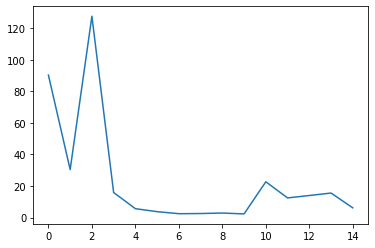

Epoch 1/15
11/11 - 8s - loss: 67.4304 - accuracy: 0.3451 - auc_160: 0.6046 - precision_160: 0.3503 - recall_160: 0.3451 - f1_score: 0.2428 - val_loss: 76.0042 - val_accuracy: 0.5588 - val_auc_160: 0.7059 - val_precision_160: 0.5588 - val_recall_160: 0.5588 - val_f1_score: 0.1792 - 8s/epoch - 715ms/step
Epoch 2/15
11/11 - 0s - loss: 20.6656 - accuracy: 0.3038 - auc_160: 0.5475 - precision_160: 0.3015 - recall_160: 0.2979 - f1_score: 0.2266 - val_loss: 128.3391 - val_accuracy: 0.5588 - val_auc_160: 0.7059 - val_precision_160: 0.5588 - val_recall_160: 0.5588 - val_f1_score: 0.1792 - 411ms/epoch - 37ms/step
Epoch 3/15
11/11 - 0s - loss: 17.3981 - accuracy: 0.3805 - auc_160: 0.6246 - precision_160: 0.3821 - recall_160: 0.3776 - f1_score: 0.2737 - val_loss: 23.3399 - val_accuracy: 0.3412 - val_auc_160: 0.5715 - val_precision_160: 0.3412 - val_recall_160: 0.3412 - val_f1_score: 0.1387 - 341ms/epoch - 31ms/step
Epoch 4/15
11/11 - 0s - loss: 7.3098 - accuracy: 0.4808 - auc_160: 0.7458 - precisi

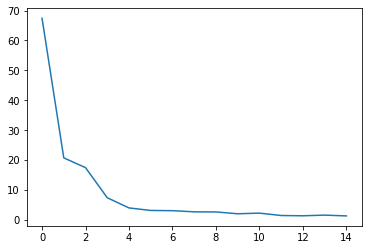

Epoch 1/15
11/11 - 8s - loss: 115.0993 - accuracy: 0.3265 - auc_161: 0.5572 - precision_161: 0.3242 - recall_161: 0.3118 - f1_score: 0.2309 - val_loss: 113.5000 - val_accuracy: 0.5503 - val_auc_161: 0.7002 - val_precision_161: 0.5503 - val_recall_161: 0.5503 - val_f1_score: 0.1775 - 8s/epoch - 689ms/step
Epoch 2/15
11/11 - 0s - loss: 11.2623 - accuracy: 0.4382 - auc_161: 0.6486 - precision_161: 0.4358 - recall_161: 0.4294 - f1_score: 0.3309 - val_loss: 17.2394 - val_accuracy: 0.4379 - val_auc_161: 0.6534 - val_precision_161: 0.4379 - val_recall_161: 0.4379 - val_f1_score: 0.2201 - 363ms/epoch - 33ms/step
Epoch 3/15
11/11 - 0s - loss: 26.9390 - accuracy: 0.5147 - auc_161: 0.7299 - precision_161: 0.5208 - recall_161: 0.5147 - f1_score: 0.3649 - val_loss: 40.4468 - val_accuracy: 0.3550 - val_auc_161: 0.5700 - val_precision_161: 0.3550 - val_recall_161: 0.3550 - val_f1_score: 0.1310 - 382ms/epoch - 35ms/step
Epoch 4/15
11/11 - 0s - loss: 9.8417 - accuracy: 0.4412 - auc_161: 0.6746 - precis

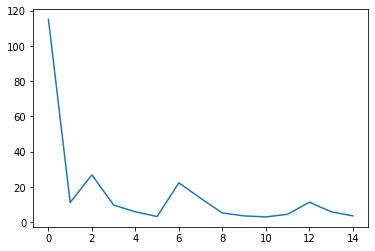

In [47]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(early_X):
                            X_train, X_val = early_X[train_index], early_X[val_index]
                            y_train, y_val = early_y[train_index], early_y[val_index]
                            early_RCNN = build_RCNN(early_features, n_length, early_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(early_RCNN, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > early_best_rcnn_acc) and (history['val_roc_auc'] > early_best_rcnn_auc):
                                early_best_rcnn_acc = history['val_accuracy']
                                early_best_rcnn_auc = history['val_roc_auc']
                                early_rcnn_loss = history['loss']
                                early_best_rcnn_model = early_RCNN
                                early_rcnn_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': float("inf") }

## 3. Late Fusion - Fusion is performed at decision level

In late fusion, I test two approaches, in both uni-modal classifiers are trained individually, and then either: 

- Their final dense (decision) layer is concatenated to produce the final prediction; or 

- Ensemble the uni-modal classifiers.

Just as with early fusion, we have the issue that the face modality is missing about half of the times and therefore, I can only use late fusion if both modalities are present.

In [48]:
body_X_train, body_X_test, y_train, y_test = load_latefusion_dataset('processed', 'skeleton')
body_X = body_X_train.copy()
y = y_train.copy()

print(body_X_train.shape, y_train.shape)
print(body_X_test.shape, y_test.shape)

n_length, body_features, body_outputs = body_X_train.shape[2], body_X_train.shape[-1], y_train.shape[1]

(509, 1, 350, 38) (509, 4)
(88, 1, 350, 38) (88, 4)


In [50]:
umild, lmoderate, lmild, umoderate = np.sum(y_train, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

### BiLSTM (concatenate decision layer)

In [ ]:
late_best_biconv_acc = 0.0
late_best_biconv_auc = 0.0
late_biconv_loss = float("inf")
late_best_biconv_model = None
late_biconv_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

In [ ]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(body_X):
                            body_X_train, body_X_val = body_X[train_index], body_X[val_index]
                            face_X_train, face_X_val = face_X[train_index], face_X[val_index]
                            y_train, y_val = y[train_index], y[val_index]
                            late_biLSTM = build_fusioned_biLSTM(body_features, face_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train_fusioned(late_biLSTM, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > late_best_biconv_acc) and (history['val_roc_auc'] > late_best_biconv_auc):
                                late_best_biconv_acc = history['val_accuracy']
                                late_best_biconv_auc = history['val_roc_auc']
                                late_biconv_loss = history['loss']
                                late_best_biconv_model = late_biLSTM
                                late_biconv_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': float("inf") }

### CNN+LSTM (concatenate decision layer)

In [ ]:
late_best_cnn_acc = 0.0
late_best_cnn_auc = 0.0
late_cnn_loss = float("inf")
late_best_cnn_model = None
late_cnn_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 48s - loss: 3.0473 - accuracy: 0.4631 - auc_165: 0.7221 - precision_165: 0.0000e+00 - recall_165: 0.0000e+00 - f1_score: 0.2059 - val_loss: 1.1717 - val_accuracy: 0.4706 - val_auc_165: 0.7710 - val_precision_165: 0.0000e+00 - val_recall_165: 0.0000e+00 - val_f1_score: 0.1600 - 48s/epoch - 4s/step
Epoch 2/15
11/11 - 1s - loss: 3.2784 - accuracy: 0.4602 - auc_165: 0.7269 - precision_165: 0.0000e+00 - recall_165: 0.0000e+00 - f1_score: 0.1810 - val_loss: 1.3166 - val_accuracy: 0.2588 - val_auc_165: 0.5635 - val_precision_165: 0.0000e+00 - val_recall_165: 0.0000e+00 - val_f1_score: 0.1310 - 544ms/epoch - 49ms/step
Epoch 3/15
11/11 - 1s - loss: 2.9625 - accuracy: 0.3658 - auc_165: 0.6317 - precision_165: 0.0000e+00 - recall_165: 0.0000e+00 - f1_score: 0.1898 - val_loss: 1.2921 - val_accuracy: 0.2647 - val_auc_165: 0.5667 - val_precision_165: 0.0000e+00 - val_recall_165: 0.0000e+00 - val_f1_score: 0.1324 - 618ms/epoch - 56ms/step
Epoch 4/15
11/11 - 1s - loss: 2.8686 - accu

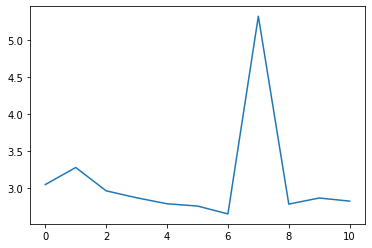

Epoch 1/15
11/11 - 34s - loss: 2.5802 - accuracy: 0.1003 - auc_166: 0.5526 - precision_166: 0.0000e+00 - recall_166: 0.0000e+00 - f1_score: 0.0590 - val_loss: 1.2821 - val_accuracy: 0.0941 - val_auc_166: 0.5246 - val_precision_166: 0.0000e+00 - val_recall_166: 0.0000e+00 - val_f1_score: 0.0430 - 34s/epoch - 3s/step
Epoch 2/15
11/11 - 1s - loss: 2.6582 - accuracy: 0.3245 - auc_166: 0.6614 - precision_166: 0.0000e+00 - recall_166: 0.0000e+00 - f1_score: 0.2026 - val_loss: 1.2511 - val_accuracy: 0.5059 - val_auc_166: 0.8002 - val_precision_166: 0.0000e+00 - val_recall_166: 0.0000e+00 - val_f1_score: 0.2590 - 605ms/epoch - 55ms/step
Epoch 3/15
11/11 - 1s - loss: 2.5845 - accuracy: 0.4779 - auc_166: 0.7184 - precision_166: 0.0000e+00 - recall_166: 0.0000e+00 - f1_score: 0.2547 - val_loss: 1.2887 - val_accuracy: 0.4706 - val_auc_166: 0.6734 - val_precision_166: 0.0000e+00 - val_recall_166: 0.0000e+00 - val_f1_score: 0.2851 - 622ms/epoch - 57ms/step
Epoch 4/15
11/11 - 1s - loss: 2.5451 - accu

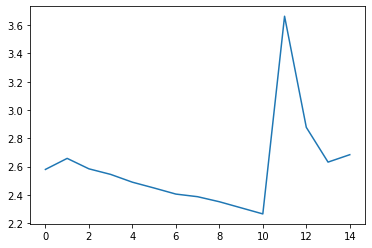

Epoch 1/15
11/11 - 34s - loss: 2.5801 - accuracy: 0.3647 - auc_167: 0.6876 - precision_167: 0.0000e+00 - recall_167: 0.0000e+00 - f1_score: 0.1962 - val_loss: 1.2131 - val_accuracy: 0.5503 - val_auc_167: 0.7778 - val_precision_167: 0.0000e+00 - val_recall_167: 0.0000e+00 - val_f1_score: 0.1775 - 34s/epoch - 3s/step
Epoch 2/15
11/11 - 1s - loss: 2.5632 - accuracy: 0.3794 - auc_167: 0.7201 - precision_167: 0.0000e+00 - recall_167: 0.0000e+00 - f1_score: 0.2047 - val_loss: 1.2222 - val_accuracy: 0.2485 - val_auc_167: 0.6845 - val_precision_167: 0.0000e+00 - val_recall_167: 0.0000e+00 - val_f1_score: 0.1597 - 546ms/epoch - 50ms/step
Epoch 3/15
11/11 - 1s - loss: 2.6510 - accuracy: 0.3735 - auc_167: 0.7046 - precision_167: 0.0000e+00 - recall_167: 0.0000e+00 - f1_score: 0.2149 - val_loss: 1.2332 - val_accuracy: 0.4320 - val_auc_167: 0.7052 - val_precision_167: 0.0000e+00 - val_recall_167: 0.0000e+00 - val_f1_score: 0.2698 - 595ms/epoch - 54ms/step
Epoch 4/15
11/11 - 1s - loss: 2.4836 - accu

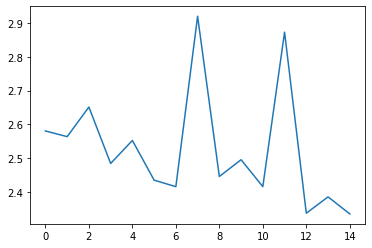

In [52]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(body_X):
                            body_X_train, body_X_val = body_X[train_index], body_X[val_index]
                            face_X_train, face_X_val = face_X[train_index], face_X[val_index]
                            y_train, y_val = y[train_index], y[val_index]
                            late_CNN = build_fusioned_CNN(body_features, face_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train_fusioned(late_CNN, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > late_best_cnn_acc) and (history['val_roc_auc'] > late_best_cnn_auc):
                                late_best_cnn_acc = history['val_accuracy']
                                late_best_cnn_auc = history['val_roc_auc']
                                late_cnn_loss = history['loss']
                                late_best_cnn_model = late_CNN
                                late_cnn_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': float("inf") }

### ConvLSTM (concatenate decision layer)

In [ ]:
late_best_lstm_acc = 0.0
late_best_lstm_auc = 0.0
late_lstm_loss = float("inf")
late_best_lstm_model = None
late_lstm_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 48s - loss: 15.8208 - accuracy: 0.3215 - auc_168: 0.6316 - precision_168: 0.3208 - recall_168: 0.3009 - f1_score: 0.2229 - val_loss: 1.1402 - val_accuracy: 0.4412 - val_auc_168: 0.7106 - val_precision_168: 0.4167 - val_recall_168: 0.2059 - val_f1_score: 0.1686 - 48s/epoch - 4s/step
Epoch 2/15
11/11 - 2s - loss: 4.7793 - accuracy: 0.3481 - auc_168: 0.6497 - precision_168: 0.3463 - recall_168: 0.2094 - f1_score: 0.2324 - val_loss: 1.6741 - val_accuracy: 0.1529 - val_auc_168: 0.4921 - val_precision_168: 0.3000 - val_recall_168: 0.0176 - val_f1_score: 0.0992 - 2s/epoch - 194ms/step
Epoch 3/15
11/11 - 2s - loss: 3.1821 - accuracy: 0.3835 - auc_168: 0.7140 - precision_168: 0.5333 - recall_168: 0.1180 - f1_score: 0.2640 - val_loss: 1.3077 - val_accuracy: 0.2588 - val_auc_168: 0.5767 - val_precision_168: 0.3333 - val_recall_168: 0.0235 - val_f1_score: 0.1778 - 2s/epoch - 188ms/step
Epoch 4/15
11/11 - 2s - loss: 2.9584 - accuracy: 0.3392 - auc_168: 0.6041 - precision_168: 0.5

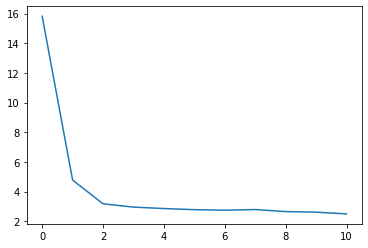

Epoch 1/15
11/11 - 56s - loss: 6.0979 - accuracy: 0.2684 - auc_169: 0.5815 - precision_169: 0.2181 - recall_169: 0.1563 - f1_score: 0.2170 - val_loss: 1.8915 - val_accuracy: 0.4412 - val_auc_169: 0.6544 - val_precision_169: 0.6316 - val_recall_169: 0.2118 - val_f1_score: 0.2322 - 56s/epoch - 5s/step
Epoch 2/15
11/11 - 2s - loss: 3.0811 - accuracy: 0.2507 - auc_169: 0.5805 - precision_169: 0.3889 - recall_169: 0.0413 - f1_score: 0.1754 - val_loss: 1.2573 - val_accuracy: 0.4176 - val_auc_169: 0.6656 - val_precision_169: 0.0000e+00 - val_recall_169: 0.0000e+00 - val_f1_score: 0.2280 - 2s/epoch - 186ms/step
Epoch 3/15
11/11 - 2s - loss: 2.5658 - accuracy: 0.4661 - auc_169: 0.7368 - precision_169: 0.8889 - recall_169: 0.0236 - f1_score: 0.2382 - val_loss: 1.1687 - val_accuracy: 0.5588 - val_auc_169: 0.7874 - val_precision_169: 0.2857 - val_recall_169: 0.0118 - val_f1_score: 0.2373 - 2s/epoch - 190ms/step
Epoch 4/15
11/11 - 2s - loss: 2.4538 - accuracy: 0.3097 - auc_169: 0.6814 - precision_1

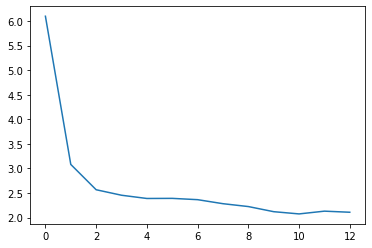

Epoch 1/15
11/11 - 49s - loss: 11.2686 - accuracy: 0.3382 - auc_170: 0.6382 - precision_170: 0.3708 - recall_170: 0.2912 - f1_score: 0.2270 - val_loss: 1.2353 - val_accuracy: 0.3846 - val_auc_170: 0.7176 - val_precision_170: 0.4250 - val_recall_170: 0.1006 - val_f1_score: 0.2068 - 49s/epoch - 4s/step
Epoch 2/15
11/11 - 2s - loss: 3.5286 - accuracy: 0.3324 - auc_170: 0.6572 - precision_170: 0.3818 - recall_170: 0.0618 - f1_score: 0.2275 - val_loss: 1.4031 - val_accuracy: 0.3136 - val_auc_170: 0.6052 - val_precision_170: 0.3077 - val_recall_170: 0.0947 - val_f1_score: 0.2300 - 2s/epoch - 189ms/step
Epoch 3/15
11/11 - 2s - loss: 3.3260 - accuracy: 0.3882 - auc_170: 0.6702 - precision_170: 0.4870 - recall_170: 0.2206 - f1_score: 0.2634 - val_loss: 1.5777 - val_accuracy: 0.3787 - val_auc_170: 0.7371 - val_precision_170: 0.3973 - val_recall_170: 0.3432 - val_f1_score: 0.1751 - 2s/epoch - 187ms/step
Epoch 4/15
11/11 - 2s - loss: 4.7671 - accuracy: 0.2265 - auc_170: 0.5320 - precision_170: 0.4

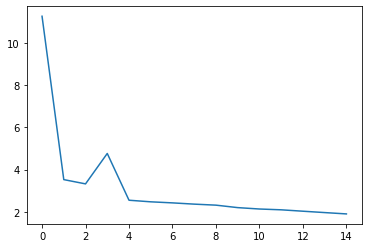

In [53]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(body_X):
                            body_X_train, body_X_val = body_X[train_index], body_X[val_index]
                            face_X_train, face_X_val = face_X[train_index], face_X[val_index]
                            y_train, y_val = y[train_index], y[val_index]
                            late_convLSTM = build_fusioned_convLSTM(body_features, face_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train_fusioned(late_convLSTM, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > late_best_lstm_acc) and (history['val_roc_auc'] > late_best_lstm_auc):
                                late_best_lstm_acc = history['val_accuracy']
                                late_best_lstm_auc = history['val_roc_auc']
                                late_lstm_loss = history['loss']
                                late_best_lstm_model = late_convLSTM
                                late_lstm_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': float("inf") }

### RCNN (concatenate decision layer)

In [ ]:
late_best_rcnn_acc = 0.0
late_best_rcnn_auc = 0.0
late_rcnn_loss = float("inf")
late_best_rcnn_model = None
late_rcnn_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 11s - loss: 70.0580 - accuracy: 0.3422 - auc_171: 0.5699 - precision_171: 0.3434 - recall_171: 0.3363 - f1_score: 0.2438 - val_loss: 106.4755 - val_accuracy: 0.4706 - val_auc_171: 0.6471 - val_precision_171: 0.4706 - val_recall_171: 0.4706 - val_f1_score: 0.1600 - 11s/epoch - 988ms/step
Epoch 2/15
11/11 - 0s - loss: 72.5752 - accuracy: 0.4454 - auc_171: 0.6571 - precision_171: 0.4454 - recall_171: 0.4454 - f1_score: 0.2864 - val_loss: 40.3527 - val_accuracy: 0.4059 - val_auc_171: 0.6071 - val_precision_171: 0.4059 - val_recall_171: 0.4059 - val_f1_score: 0.1481 - 497ms/epoch - 45ms/step
Epoch 3/15
11/11 - 1s - loss: 27.5731 - accuracy: 0.2950 - auc_171: 0.5414 - precision_171: 0.2959 - recall_171: 0.2950 - f1_score: 0.2359 - val_loss: 47.3789 - val_accuracy: 0.4294 - val_auc_171: 0.6195 - val_precision_171: 0.4294 - val_recall_171: 0.4294 - val_f1_score: 0.1502 - 505ms/epoch - 46ms/step
Epoch 4/15
11/11 - 1s - loss: 15.0670 - accuracy: 0.4572 - auc_171: 0.6692 - prec

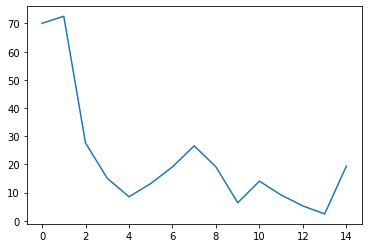

Epoch 1/15
11/11 - 11s - loss: 76.0884 - accuracy: 0.3540 - auc_172: 0.5780 - precision_172: 0.3494 - recall_172: 0.3422 - f1_score: 0.2451 - val_loss: 303.7135 - val_accuracy: 0.3412 - val_auc_172: 0.5608 - val_precision_172: 0.3412 - val_recall_172: 0.3412 - val_f1_score: 0.1272 - 11s/epoch - 996ms/step
Epoch 2/15
11/11 - 0s - loss: 51.7237 - accuracy: 0.2950 - auc_172: 0.5396 - precision_172: 0.2929 - recall_172: 0.2920 - f1_score: 0.2250 - val_loss: 67.5061 - val_accuracy: 0.5588 - val_auc_172: 0.7059 - val_precision_172: 0.5588 - val_recall_172: 0.5588 - val_f1_score: 0.1792 - 494ms/epoch - 45ms/step
Epoch 3/15
11/11 - 1s - loss: 22.0807 - accuracy: 0.3982 - auc_172: 0.6291 - precision_172: 0.3982 - recall_172: 0.3982 - f1_score: 0.2940 - val_loss: 37.9688 - val_accuracy: 0.5588 - val_auc_172: 0.7059 - val_precision_172: 0.5588 - val_recall_172: 0.5588 - val_f1_score: 0.1792 - 519ms/epoch - 47ms/step
Epoch 4/15
11/11 - 0s - loss: 8.9419 - accuracy: 0.4484 - auc_172: 0.6985 - preci

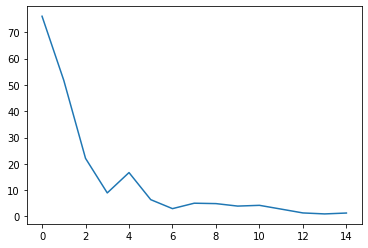

Epoch 1/15
11/11 - 11s - loss: 75.0866 - accuracy: 0.2912 - auc_173: 0.5390 - precision_173: 0.2934 - recall_173: 0.2882 - f1_score: 0.2006 - val_loss: 145.8048 - val_accuracy: 0.3550 - val_auc_173: 0.5700 - val_precision_173: 0.3550 - val_recall_173: 0.3550 - val_f1_score: 0.1310 - 11s/epoch - 997ms/step
Epoch 2/15
11/11 - 0s - loss: 27.6608 - accuracy: 0.4265 - auc_173: 0.6720 - precision_173: 0.4260 - recall_173: 0.4235 - f1_score: 0.3077 - val_loss: 29.6458 - val_accuracy: 0.5030 - val_auc_173: 0.6707 - val_precision_173: 0.5030 - val_recall_173: 0.5030 - val_f1_score: 0.1700 - 491ms/epoch - 45ms/step
Epoch 3/15
11/11 - 1s - loss: 7.2696 - accuracy: 0.4853 - auc_173: 0.7211 - precision_173: 0.4882 - recall_173: 0.4853 - f1_score: 0.3822 - val_loss: 14.2946 - val_accuracy: 0.4379 - val_auc_173: 0.6657 - val_precision_173: 0.4379 - val_recall_173: 0.4379 - val_f1_score: 0.2288 - 517ms/epoch - 47ms/step
Epoch 4/15
11/11 - 0s - loss: 2.8308 - accuracy: 0.6029 - auc_173: 0.8260 - precis

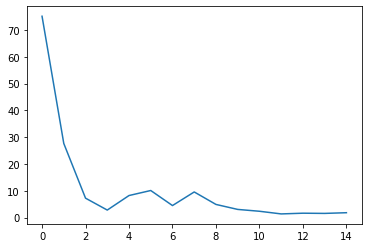

In [54]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(body_X):
                            body_X_train, body_X_val = body_X[train_index], body_X[val_index]
                            face_X_train, face_X_val = face_X[train_index], face_X[val_index]
                            y_train, y_val = y[train_index], y[val_index]
                            late_RCNN = build_fusioned_RCNN(body_features, face_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train_fusioned(late_RCNN, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > late_best_rcnn_acc) and (history['val_roc_auc'] > late_best_rcnn_auc):
                                late_best_rcnn_acc = history['val_accuracy']
                                late_best_rcnn_auc = history['val_roc_auc']
                                late_rcnn_loss = history['loss']
                                late_best_rcnn_model = late_RCNN
                                late_rcnn_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': float("inf") }

### Convert Uni-modal Approaches to Ensemble Members

In [55]:
#biLSTM_body_model = build_biLSTM(body_features, n_length, body_outputs, neurons=body_biconv_values['neurons'], kernel_size=body_biconv_values['kernel_size'], activation=body_biconv_values['activation'], kernel_initializer=body_biconv_values['kernel_initializer'], dropout=body_biconv_values['dropout'])
#train(biLSTM_body_model, body_X_train, y_train, body_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)

Epoch 1/15
11/11 - 81s - loss: 26.8714 - accuracy: 0.3588 - auc_174: 0.6220 - precision_174: 0.3522 - recall_174: 0.3118 - f1_score: 0.2416 - val_loss: 2.4095 - val_accuracy: 0.0888 - val_auc_174: 0.4789 - val_precision_174: 0.0863 - val_recall_174: 0.0710 - val_f1_score: 0.0446 - 81s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 9.4181 - accuracy: 0.2529 - auc_174: 0.5950 - precision_174: 0.2531 - recall_174: 0.1824 - f1_score: 0.1905 - val_loss: 3.2216 - val_accuracy: 0.5503 - val_auc_174: 0.7020 - val_precision_174: 0.5503 - val_recall_174: 0.5503 - val_f1_score: 0.1775 - 3s/epoch - 272ms/step
Epoch 3/15
11/11 - 3s - loss: 6.1918 - accuracy: 0.2971 - auc_174: 0.6899 - precision_174: 0.3856 - recall_174: 0.1735 - f1_score: 0.2201 - val_loss: 1.5029 - val_accuracy: 0.0888 - val_auc_174: 0.5814 - val_precision_174: 0.0888 - val_recall_174: 0.0888 - val_f1_score: 0.0408 - 3s/epoch - 271ms/step
Epoch 4/15
11/11 - 3s - loss: 5.4459 - accuracy: 0.0912 - auc_174: 0.5602 - precision_174: 0.1

In [56]:
biLSTM_body_member = KerasMember(name="Body Model", keras_model=body_best_biconv_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
biLSTM_face_member = KerasMember(name="Face Model", keras_model=face_best_biconv_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))

NameError: name 'face_biConvLSTM' is not defined

In [ ]:
#cnn_body_model = build_CNN(body_features, n_length, body_outputs)
#train(cnn_body_model, body_X_train, y_train, body_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)

Epoch 1/50
1/1 - 5s - loss: 1.6530 - accuracy: 0.0775 - auc_49: 0.2763 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.0523 - val_loss: 1.1080 - val_accuracy: 0.0625 - val_auc_49: 0.3019 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.0392 - 5s/epoch - 5s/step
Epoch 2/50
1/1 - 0s - loss: 1.6544 - accuracy: 0.0775 - auc_49: 0.2986 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.0480 - val_loss: 1.1039 - val_accuracy: 0.1250 - val_auc_49: 0.4467 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.1088 - 275ms/epoch - 275ms/step
Epoch 3/50
1/1 - 0s - loss: 1.6536 - accuracy: 0.1395 - auc_49: 0.5328 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.1105 - val_loss: 1.1086 - val_accuracy: 0.0625 - val_auc_49: 0.4336 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.0392 - 211ms/epoch - 211ms/step
Epoch 4/50
1/1 - 0s - loss: 1.6502 - accuracy: 0.0775 - auc_49: 0.5

In [ ]:
cnn_body_member = KerasMember(name="Body Model", keras_model=body_best_cnn_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
cnn_face_member = KerasMember(name="Face Model", keras_model=face_best_cnn_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))

In [ ]:
#convLSTM_body_model = build_convLSTM(body_features, n_length, body_outputs)
#train(convLSTM_body_model, body_X_train, y_train, body_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)

Epoch 1/50
1/1 - 6s - loss: 10.2354 - accuracy: 0.3256 - auc_50: 0.5287 - precision_50: 0.3281 - recall_50: 0.3256 - f1_score: 0.2355 - val_loss: 31.8970 - val_accuracy: 0.2969 - val_auc_50: 0.4515 - val_precision_50: 0.2969 - val_recall_50: 0.2969 - val_f1_score: 0.1957 - 6s/epoch - 6s/step
Epoch 2/50
1/1 - 1s - loss: 34.2097 - accuracy: 0.2248 - auc_50: 0.3856 - precision_50: 0.2248 - recall_50: 0.2248 - f1_score: 0.1853 - val_loss: 6.4864 - val_accuracy: 0.4844 - val_auc_50: 0.6185 - val_precision_50: 0.4844 - val_recall_50: 0.4844 - val_f1_score: 0.2271 - 714ms/epoch - 714ms/step
Epoch 3/50
1/1 - 1s - loss: 10.7796 - accuracy: 0.5969 - auc_50: 0.6958 - precision_50: 0.5969 - recall_50: 0.5969 - f1_score: 0.2891 - val_loss: 2.7605 - val_accuracy: 0.1250 - val_auc_50: 0.3309 - val_precision_50: 0.1148 - val_recall_50: 0.1094 - val_f1_score: 0.1238 - 625ms/epoch - 625ms/step
Epoch 4/50
1/1 - 1s - loss: 3.4214 - accuracy: 0.1163 - auc_50: 0.3075 - precision_50: 0.1148 - recall_50: 0.10

In [ ]:
convLSTM_body_member = KerasMember(name="Body Model", keras_model=body_best_lstm_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
convLSTM_face_member = KerasMember(name="Face Model", keras_model=face_best_lstm_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))

In [ ]:
#rcnn_body_model = build_RCNN(body_features, n_length, body_outputs)
#train(rcnn_body_model, body_X_train, y_train, body_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)

Epoch 1/50
1/1 - 2s - loss: 3.3719 - accuracy: 0.3953 - auc_51: 0.5203 - precision_51: 0.3871 - recall_51: 0.3721 - f1_score: 0.3668 - val_loss: 1949.0488 - val_accuracy: 0.4219 - val_auc_51: 0.5664 - val_precision_51: 0.4219 - val_recall_51: 0.4219 - val_f1_score: 0.1978 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 32.4957 - accuracy: 0.4109 - auc_51: 0.5797 - precision_51: 0.4109 - recall_51: 0.4109 - f1_score: 0.3758 - val_loss: 789.1389 - val_accuracy: 0.0625 - val_auc_51: 0.2969 - val_precision_51: 0.0625 - val_recall_51: 0.0625 - val_f1_score: 0.0392 - 219ms/epoch - 219ms/step
Epoch 3/50
1/1 - 0s - loss: 21.3562 - accuracy: 0.4496 - auc_51: 0.5975 - precision_51: 0.4496 - recall_51: 0.4496 - f1_score: 0.3815 - val_loss: 185.4648 - val_accuracy: 0.5156 - val_auc_51: 0.6367 - val_precision_51: 0.5156 - val_recall_51: 0.5156 - val_f1_score: 0.2268 - 285ms/epoch - 285ms/step
Epoch 4/50
1/1 - 0s - loss: 8.8097 - accuracy: 0.5814 - auc_51: 0.7163 - precision_51: 0.5814 - recall_51:

In [ ]:
rcnn_body_member = KerasMember(name="Body Model", keras_model=body_best_rcnn_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
rcnn_face_member = KerasMember(name="Face Model", keras_model=face_best_rcnn_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))

### Dirichlet Markov Ensemble with weighted soft voting

In [ ]:
biLSTM_dirichletEnsemble = DirichletEnsemble()
biLSTM_dirichletEnsemble.add_member(biLSTM_body_member)
biLSTM_dirichletEnsemble.add_member(biLSTM_face_member)
biLSTM_dirichletEnsemble.fit()

In [ ]:
cnn_dirichletEnsemble = DirichletEnsemble()
cnn_dirichletEnsemble.add_member(cnn_body_member)
cnn_dirichletEnsemble.add_member(cnn_face_member)
cnn_dirichletEnsemble.fit()

In [ ]:
convLSTM_dirichletEnsemble = DirichletEnsemble()
convLSTM_dirichletEnsemble.add_member(convLSTM_body_member)
convLSTM_dirichletEnsemble.add_member(convLSTM_face_member)
convLSTM_dirichletEnsemble.fit()

In [ ]:
rcnn_dirichletEnsemble = DirichletEnsemble()
rcnn_dirichletEnsemble.add_member(rcnn_body_member)
rcnn_dirichletEnsemble.add_member(rcnn_face_member)
rcnn_dirichletEnsemble.fit()

## Performance Evaluation on Test set

### Uni-Modal (only Body/Skeleton data)

In [57]:
_, acc, auc, precision, recall, f1 = body_best_biconv_model.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

ValueError: in user code:

    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_140" is incompatible with the layer: expected shape=(None, 1, 350, 10), found shape=(None, 1, 350, 38)


In [ ]:
_, acc, auc, precision, recall, f1 = body_best_cnn_model.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('CNN+LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN+LSTM:
Accuracy: 14.44% - ROC/AUC: 0.41 - Precision: 0.00 - Recall: 0.00, F1 score: 0.06


In [ ]:
_, acc, auc, precision, recall, f1 = body_best_lstm_model.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('Convolutional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Convolutional LSTM:
Accuracy: 15.56% - ROC/AUC: 0.36 - Precision: 0.14 - Recall: 0.10, F1 score: 0.14


In [ ]:
_, acc, auc, precision, recall, f1 = body_best_rcnn_model.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 16.67% - ROC/AUC: 0.46 - Precision: 0.17 - Recall: 0.17, F1 score: 0.10


### Uni-Modal (only Facial Expression/Action Units)

In [ ]:
_, acc, auc, precision, recall, f1 = face_best_biconv_model.evaluate(face_X_test, face_y_test, verbose=0)
print('Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Bidirectional LSTM:
Accuracy: 23.81% - ROC/AUC: 0.49 - Precision: 0.19 - Recall: 0.21, F1 score: 0.25


In [ ]:
_, acc, auc, precision, recall, f1 = face_best_cnn_model.evaluate(face_X_test, face_y_test, verbose=0)
print('CNN+LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN+LSTM:
Accuracy: 33.33% - ROC/AUC: 0.48 - Precision: 0.17 - Recall: 0.21, F1 score: 0.16


In [ ]:
_, acc, auc, precision, recall, f1 = face_best_lstm_model.evaluate(face_X_test, face_y_test, verbose=0)
print('Convolutional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Convolutional LSTM:
Accuracy: 23.81% - ROC/AUC: 0.48 - Precision: 0.24 - Recall: 0.21, F1 score: 0.22


In [ ]:
_, acc, auc, precision, recall, f1 = face_best_rcnn_model.evaluate(face_X_test, face_y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 33.33% - ROC/AUC: 0.46 - Precision: 0.23 - Recall: 0.28, F1 score: 0.24


### Early Fusion (Feature Level)

In [ ]:
_, acc, auc, precision, recall, f1 = early_best_biconv_model.evaluate(early_X_test, early_y_test, verbose=0)
print('Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Bidirectional LSTM:
Accuracy: 45.24% - ROC/AUC: 0.49 - Precision: 0.00 - Recall: 0.00, F1 score: 0.17


In [ ]:
_, acc, auc, precision, recall, f1 = early_best_cnn_model.evaluate(early_X_test, early_y_test, verbose=0)
print('CNN+LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN+LSTM:
Accuracy: 11.90% - ROC/AUC: 0.40 - Precision: 0.00 - Recall: 0.00, F1 score: 0.07


In [ ]:
_, acc, auc, precision, recall, f1 = early_best_lstm_model.evaluate(early_X_test, early_y_test, verbose=0)
print('Convolutional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Convolutional LSTM:
Accuracy: 42.86% - ROC/AUC: 0.48 - Precision: 0.22 - Recall: 0.31, F1 score: 0.16


In [ ]:
_, acc, auc, precision, recall, f1 = early_best_rcnn_model.evaluate(early_X_test, early_y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 59.52% - ROC/AUC: 0.55 - Precision: 0.29 - Recall: 0.41, F1 score: 0.15


### Late Fusion (Decision Level)

In [ ]:
_, acc, auc, precision, recall, f1 = late_best_biconv_model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
print('Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Bidirectional LSTM:
Accuracy: 26.19% - ROC/AUC: 0.54 - Precision: 0.18 - Recall: 0.14, F1 score: 0.16


In [ ]:
_, acc, auc, precision, recall, f1 = late_best_cnn_model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
print('CNN+LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN+LSTM:
Accuracy: 33.33% - ROC/AUC: 0.57 - Precision: 0.22 - Recall: 0.28, F1 score: 0.19


In [ ]:
_, acc, auc, precision, recall, f1 = late_best_lstm_model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
print('Convolutional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Convolutional LSTM:
Accuracy: 38.10% - ROC/AUC: 0.46 - Precision: 0.17 - Recall: 0.24, F1 score: 0.19


In [ ]:
_, acc, auc, precision, recall, f1 = late_best_rcnn_model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 57.14% - ROC/AUC: 0.51 - Precision: 0.26 - Recall: 0.38, F1 score: 0.20


In [ ]:
print('BiLSTM Dirichlet Markov Ensemble:')
d = biLSTM_dirichletEnsemble.describe()

BiLSTM Dirichlet Markov Ensemble:
Body Model (weight: 0.0038)
Face Model (weight: 0.9962)
Accuracy: 50.00% - ROC/AUC: 0.52 - Precision: 0.43 - Recall: 0.46 - F1 score: 0.36


In [ ]:
print('CNN+LSTM Dirichlet Markov Ensemble:')
d = cnn_dirichletEnsemble.describe()

CNN+LSTM Dirichlet Markov Ensemble:
Body Model (weight: 0.9998)
Face Model (weight: 0.0002)
Accuracy: 50.00% - ROC/AUC: 0.45 - Precision: 0.25 - Recall: 0.40 - F1 score: 0.28


In [ ]:
print('ConvLSTM Dirichlet Markov Ensemble:')
d = convLSTM_dirichletEnsemble.describe()

ConvLSTM Dirichlet Markov Ensemble:
Body Model (weight: 0.0081)
Face Model (weight: 0.9919)
Accuracy: 28.57% - ROC/AUC: 0.49 - Precision: 0.33 - Recall: 0.35 - F1 score: 0.27


In [ ]:
print('RCNN Dirichlet Markov Ensemble:')
d = rcnn_dirichletEnsemble.describe()

RCNN Dirichlet Markov Ensemble:
Body Model (weight: 0.6381)
Face Model (weight: 0.3619)
Accuracy: 59.52% - ROC/AUC: 0.50 - Precision: 0.29 - Recall: 0.43 - F1 score: 0.33
